<a href="https://colab.research.google.com/github/alexhosp/startup-viability-analysis/blob/main/customer-segmentation/notebooks/01_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection for Customer Segmentation
## Introduction
This notebook focuses on collecting data to identify and segment potential customers for a proposed AI-driven gardening robot startup. We will use the Pytrends API to gather data from Google Trends. All raw data will be stored in Google Cloud Storage (GCS).
## Steps
1. [Setup and GCS Configuration](#setup-gcs-configuration)
2. [Definition of Initial Keywords](#initial-keywords-definition)
3. Data Collection
  1. [Google Trends](#google-trends)
    1. [API Authentication and Configuration](#api-authentication-configuration)
    2. [Defining Data Collection Functions](#defining-data-collection-functions)
    3. [Collect Relevant Data](#collect-relevant-data)
        1. [Collect Interest Over Time in Proposed Features](#collect-interest-features)
        2. [Collect Interest Over Time in Problems Addressed (Relevance)](#collect-interest-problems)
        3. [Collect Interest Over Time in Needs Adressed (Relevance)](#collect-interest-needs)
    4. [Clean and Transform Data](#clean-and-transform-data)
        1. [Clean and Transform Interest Over Time in Features Data](#clean-transform-features)
        2. [Clean and Transform Relevance of Problems Data](#clean-transform-problems)
        3. [Clean and Transform Relevance of Needs Data](#clean-transform-needs)
    5. [Explore the Data](#explore-the-data)
        1. [Explore Interest Over Time in Proposed Features](#explore-features)
            1.
        2. [Explore Relevance of Problems](#explore-problems)
        3. [Explore Relevance of Needs](#explore-needs)
    6. [Evaluate and Select Relevant Data](#evaluate-and-select-relevant-data)
    7. [Store Data in GCS](#store-data-in-gcs)

*Decide on how to proceed here, Twitter API might not be accessible*

* Twitter API
* Reddit API
* Google Custom Search API
5. Executing Data Collection Functions
6. Storing Data in GCS
7. Semantic Expansion of Keywords
8. Definition of Additional Keywords
9. Defining Data Collection Functions for Structured Data
* Kaggle API
* Google Dataset Search API
* UCI Machine Learning Repository API
10. Executing Data Collection for Additional Data
11. Iterative Data Collection


<a name="setup-gcs-configuration"></a>
## Setup and GCS Configuration
* Install necessary libraries
* Authenticate and access GCS
* Set up a GCS bucket for storage

In [ ]:
# Install necessary libraries
!pip install google-cloud-storage

In [19]:
# Import necessary libraries
from google.cloud import storage
import pandas as pd
from google.colab import auth

In [6]:
# Authenticate with GCP
auth.authenticate_user()

In [53]:
# Set up GCS client
project_id = 'idyllic-gear-422709-g4'
storage_client = storage.Client(project=project_id)

In [59]:
# Create a new bucket to store all data in

# Define the bucket name
bucket_name = 'startup-viability-analysis'

# Check if the bucket already exists
bucket = storage_client.bucket(bucket_name)

# Create the bucket if it does not exist

bucket = storage_client.bucket(bucket_name)
if not bucket.exists():
  bucket.storage_class = 'STANDARD'
  bucket = storage_client.create_bucket(bucket, location='us-east1')
  print(
        "Created bucket {} in {} with storage class {}".format(
            bucket.name, bucket.location, bucket.storage_class
        )
    )
else:
  print(f"Bucket {bucket_name} already exists")




Bucket startup-viability-analysis already exists


In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="initial-keywords-definition"></a>
# Definition of Initial Keywords
The initial keywords are selected to gather data on interest in the prototype's features and the relevance of the problems and needs it aims addresses.

## Read in the keyword lists from GitHub

In [ ]:
# Install necessary libraries
!pip install requests

In [10]:
# Import necessary libraries
import requests

In [11]:
# Define file paths
base_url = 'https://raw.githubusercontent.com/alexhosp/startup-viability-analysis/main/customer-segmentation/data/raw/'
files = ['features.txt', 'problems.txt', 'needs.txt']

# Retrieve text files and convert them to Python lists
features = requests.get(base_url + files[0]).text.splitlines()
problems = requests.get(base_url + files[1]).text.splitlines()
needs = requests.get(base_url + files[2]).text.splitlines()
len(needs)

30

<a name='google-trends'></a>
# Google Trends
Collect data from Google Trends using the defined keywords.

<a name='api-authentication-configuration'></a>
# Pytrends API Authentication & Configuration

In [1]:
# Install necessary libraries
!pip install pytrends
!pip install urllib3==1.25.11

In [2]:
# Import pytrends
from pytrends.request import TrendReq

In [3]:
# Initialize Pytrends
pytrends = TrendReq(hl='en-US', tz=360, timeout=(5,20), retries=2)

In [4]:
# Import datetime
from datetime import datetime, timedelta

In [5]:
# Define timeframe
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)
end_date
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')
timeframe = f'{start_date_str} {end_date_str}'
timeframe

'2021-07-02 2024-07-01'

<a name='defining-data-collection-functions'></a>
# Defining Data Collection Functions
* Define functions to collect data from Google Trends
* Fetch interest over time in features, problems and needs


## Collect interest over time
* Find out about interest in proposed features
* Find out about interest in problems (relevance)
* Find out about interest in needs (relevance)

In [6]:
# Define the batch size
batch_size = 5


# Define a function to split lists into batches
def split_into_batches(lst, batch_size):
   return [lst[i:i+batch_size] for i in range(0, len(lst), batch_size)]


In [12]:
# Split features list into 5 keyword batches
features_chunks = split_into_batches(features, batch_size)
len(features_chunks)

11

In [13]:
# Split problems list into 5 keyword batches
problems_chunks = split_into_batches(problems, batch_size)
len(problems_chunks)

5

In [14]:
# Split needs list into 5 keyword batches
needs_chunks = split_into_batches(needs, batch_size)
len(needs_chunks)

6

In [101]:
# Define a function to fetch interest over time for a list of keyword chunks
def fetch_interest_over_time(pytrends, chunks, timeframe='today 5-y'):
    """
    Fetch interest over time data from Google Trends for given chunks of keywords.

    Args:
    pytrends (TrendReq): An authenticated Google Trends API client.
    features_chunks (list of list of str): A list where each element is a list of keywords.
    timeframe (str): The timeframe for the Google Trends data (default: 'today 5-y').

    Returns:
    list of pd.DataFrame: A list of DataFrames with the interest over time data for each chunk of keywords.
    """
    dataframes = []

    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}: {chunk}")
        pytrends.build_payload(kw_list=chunk, timeframe=timeframe)
        df = pytrends.interest_over_time()
        df = df.iloc[:-1]  # Remove the last row (most recent, partial week)
        if 'isPartial' in df.columns:
            df = df.drop(columns=['isPartial'])
        # Check dataframe shape
        print(f"DataFrame shape: {df.shape}")
        dataframes.append(df)
        print(f"Processed chunk {i+1}/{len(chunks)}")
    # Get a list of dataframes
    print(f"Number of dataframes: {len(dataframes)}")
    # Combine dataframes into one
    dataframe = pd.concat(dataframes, axis=1)
    print(f"Combined dataframe shape: {dataframe.shape}")
    return dataframe


<a name='collect-relevant-data'></a>
# Collect relevant data
* Use data collection functions to collect data from Google Trends

<a name='collect-interest-features'></a>
## Collect Interest Over Time in Proposed Features

In [74]:
# Get a dataframe with interest over time in all features
features_interest_over_time_df = fetch_interest_over_time(pytrends=pytrends, chunks=features_chunks, timeframe=timeframe)
features_interest_over_time_df.tail()

Processing chunk 1/11: ['Computer vision for environmental understanding', 'Real-time monitoring sensors', 'Raspberry Pi processing for community engagement', 'Hexapod mobility and agility', 'Portable agricultural technology']
DataFrame shape: (157, 5)
Processed chunk 1/11
Processing chunk 2/11: ['Indoor and outdoor ecosystem management', 'Environmental data to mobile app', 'Robot control and monitoring app', 'Plant classification and beneficial relationships', 'Self-sufficient ecosystem design']
DataFrame shape: (157, 5)
Processed chunk 2/11
Processing chunk 3/11: ['Ecosystem health classification', 'Educational information on plants and environments', 'Modular plug-and-play design for sensors and tools', 'Real-time environment monitoring', 'Plant detection']
DataFrame shape: (157, 5)
Processed chunk 3/11
Processing chunk 4/11: ['Plant health classification', 'Plant relationship identification in ecosystems', 'Beneficial ecosystem modeling', 'Ecosystem risk detection', 'Accessible for

Computer vision for environmental understanding  \
date                                                          
2024-05-26                                                0   
2024-06-02                                                0   
2024-06-09                                                0   
2024-06-16                                                0   
2024-06-23                                                0   

            Real-time monitoring sensors  \
date                                       
2024-05-26                             0   
2024-06-02                             0   
2024-06-09                             0   
2024-06-16                            28   
2024-06-23                            29   

            Raspberry Pi processing for community engagement  \
date                                                           
2024-05-26                                                 0   
2024-06-02                                                 0   
2024-06-09                                                 0   
2024-06-16                                                 0   
2024-06-23                                                 0   

            Hexapod mobility and agility  Portable agricultural technology  \
date                                                                         
2024-05-26                             0                                 0   
2024-06-02                             0                                 0   
2024-06-09                             0                                 0   
2024-06-16                             0                                 0   
2024-06-23                             0                                 0   

            Indoor and outdoor ecosystem management  \
date                                                  
2024-05-26                                        0   
2024-06-02                                        0   
2024-06-09                                        0   
2024-06-16                                        0   
2024-06-23                                        0   

            Environmental data to mobile app  \
date                                           
2024-05-26                                 0   
2024-06-02                                 0   
2024-06-09                                 0   
2024-06-16                                 0   
2024-06-23                                 0   

            Robot control and monitoring app  \
date                                           
2024-05-26                                 0   
2024-06-02                                 0   
2024-06-09                                 0   
2024-06-16                                 0   
2024-06-23                                 0   

            Plant classification and beneficial relationships  \
date                                                            
2024-05-26                                                  0   
2024-06-02                                                  0   
2024-06-09                                                  0   
2024-06-16                                                  0   
2024-06-23                                                  0   

            Self-sufficient ecosystem design  ...  \
date                                          ...   
2024-05-26                                 0  ...   
2024-06-02                                 0  ...   
2024-06-09                                 0  ...   
2024-06-16                                 0  ...   
2024-06-23                                 0  ...   

            Adaptive algorithms for environmental conditions  \
date                                                           
2024-05-26                                                 0   
2024-06-02                                                 0   
2024-06-09                                                 0   
2024-06-16                                               

<a name='collect-interest-problems'></a>
## Collect Interest Over Time in Problems Addressed by the Prototype

In [102]:
# Get a dataframe with interest over time in all problems (relevance)
problems_interest_over_time = fetch_interest_over_time(pytrends=pytrends, chunks=problems_chunks, timeframe=timeframe)
problems_interest_over_time.tail()

Processing chunk 1/5: ['Lack of portability in automated farming', 'No biological understanding in gardening automation', 'Monoculture in agriculture', 'Long-distance food transport', 'Disconnect between people and food sources']
DataFrame shape: (157, 5)
Processed chunk 1/5
Processing chunk 2/5: ['Use of preservatives and pesticides in produce', 'Separation of food production from natural ecosystems', 'Lack of ecosystem integration in automated food production', 'Lack of natural environment in agricultural innovation', 'Inaccessibility of personal gardening automation']
DataFrame shape: (157, 5)
Processed chunk 2/5
Processing chunk 3/5: ['Limited educational resources in gardening tech', 'Lack of versatile agricultural robots for indoor and outdoor use', 'Inefficient energy and resource use in automated farming solutions', 'Inability to create self-sufficient ecosystems with current tech', 'Lack of understanding of the natural world']
DataFrame shape: (157, 5)
Processed chunk 3/5
Proc

Lack of portability in automated farming  \
date                                                   
2024-05-26                                         0   
2024-06-02                                         0   
2024-06-09                                         0   
2024-06-16                                         0   
2024-06-23                                         0   

            No biological understanding in gardening automation  \
date                                                              
2024-05-26                                                  0     
2024-06-02                                                  0     
2024-06-09                                                  0     
2024-06-16                                                  0     
2024-06-23                                                  0     

            Monoculture in agriculture  Long-distance food transport  \
date                                                                   
2024-05-26                           0                             0   
2024-06-02                           0                             0   
2024-06-09                           0                             0   
2024-06-16                          13                             0   
2024-06-23                          16                             0   

            Disconnect between people and food sources  \
date                                                     
2024-05-26                                           0   
2024-06-02                                           0   
2024-06-09                                           0   
2024-06-16                                           0   
2024-06-23                                           0   

            Use of preservatives and pesticides in produce  \
date                                                         
2024-05-26                                               0   
2024-06-02                                               0   
2024-06-09                                               0   
2024-06-16                                               0   
2024-06-23                                               0   

            Separation of food production from natural ecosystems  \
date                                                                
2024-05-26                                                  0       
2024-06-02                                                  0       
2024-06-09                                                  0       
2024-06-16                                                  0       
2024-06-23                                                  0       

            Lack of ecosystem integration in automated food production  \
date                                                                     
2024-05-26                                                  0            
2024-06-02                                                  0            
2024-06-09                                                  0            
2024-06-16                                                  0            
2024-06-23                                                  0            

            Lack of natural environment in agricultural innovation  \
date                                                                 
2024-05-26                                                  0        
2024-06-02                                                  0        
2024-06-09                                                  0        
2024-06-16                                                  0        
2024-06-23                                                  0        

            Inaccessibility of personal gardening automation  ...  \
date                                                          ...   
2024-05-26                                                 0  ...   
2024-06-02                                                 0  ...   
2024-06-09                      

<a name='collect-interest-needs'></a>
## Collect Interest Over Time in Needs Addressed by the Prototype

In [130]:
# Get a dataframe with interest in time in all needs (relevance of needs)
needs_interest_over_time = fetch_interest_over_time(pytrends=pytrends, chunks=needs_chunks, timeframe=timeframe)
needs_interest_over_time.tail(3)

Processing chunk 1/6: ['Sustainable food production', 'Natural and organic growing methods', 'Personal involvement in food growing', 'Efficient and localized agriculture', 'Educational AI']
DataFrame shape: (157, 5)
Processed chunk 1/6
Processing chunk 2/6: ['Robotics for Ecosystem Health', 'User-friendly gardening automation', 'Versatile farming solutions for different environments', 'Real-time environmental data for planting', 'Portable and easy-to-use agricultural technology']
DataFrame shape: (157, 5)
Processed chunk 2/6
Processing chunk 3/6: ['Ecosystem-aware agricultural technology', 'Tools for diverse plant ecosystems', 'Automated sustainable gardening tools', 'Bridge gap between humans and nature', 'Scalable automated gardening system']
DataFrame shape: (157, 5)
Processed chunk 3/6
Processing chunk 4/6: ['Affordable automated farming solution', 'Simple set-up gardening solution', 'Minimize environmental impact with local food', 'Real-time feedback on ecosystem health', 'Utilize

Sustainable food production  Natural and organic growing methods  \
date                                                                           
2024-06-09                           30                                    0   
2024-06-16                           20                                    0   
2024-06-23                           24                                    1   

            Personal involvement in food growing  \
date                                               
2024-06-09                                     0   
2024-06-16                                     0   
2024-06-23                                     0   

            Efficient and localized agriculture  Educational AI  \
date                                                              
2024-06-09                                    0              67   
2024-06-16                                    0              65   
2024-06-23                                    0              79   

            Robotics for Ecosystem Health  User-friendly gardening automation  \
date                                                                            
2024-06-09                              0                                   0   
2024-06-16                              0                                   0   
2024-06-23                              0                                   0   

            Versatile farming solutions for different environments  \
date                                                                 
2024-06-09                                                  0        
2024-06-16                                                  0        
2024-06-23                                                  0        

            Real-time environmental data for planting  \
date                                                    
2024-06-09                                          0   
2024-06-16                                          0   
2024-06-23                                          0   

            Portable and easy-to-use agricultural technology  ...  \
date                                                          ...   
2024-06-09                                                 0  ...   
2024-06-16                                                 0  ...   
2024-06-23                                                 0  ...   

            Access and interpret environmental data  \
date                                                  
2024-06-09                                        0   
2024-06-16                                        0   
2024-06-23                                        0   

            Reduce food waste with optimized conditions  \
date                                                      
2024-06-09                                            0   
2024-06-16                                            0   
2024-06-23                                            0   

            Community engagement in ecosystems and food  \
date                                                      
2024-06-09                                            0   
2024-06-16                                          100   
2024-06-23                                            0   

            Nutritious and pesticide-free food  \
date                                             
2024-06-09                                   0   
2024-06-16                                   0   
2024-06-23                                   0   

            Food security with adaptable automated agriculture  \
date                                                             
2024-06-09                                                  0    
2024-06-16                                                  0    
2024-06-23                                                  0    

            Improved relationship with food  Collect data on nature  \
date                                                                  
2024-06-09                       

<a name='clean-and-transform-data'></a>
# Clean and Transform Data
* Clean and transform all collected data for analysis
* Remove duplicate and irrelevant entries
* Sort data and create new relevant features


<a name='clean-transform-features'></a>
## Clean and Transform Interest Over Time in Proposed Features Data
* Ensure the data does not contain duplicate or irrelevant entries.
* Remove empty columns and store them in a dataframe for further analysis

In [78]:
features_interest_over_time_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2021-06-27 to 2024-06-23
Data columns (total 55 columns):
 #   Column                                                        Non-Null Count  Dtype
---  ------                                                        --------------  -----
 0   Computer vision for environmental understanding               157 non-null    int64
 1   Real-time monitoring sensors                                  157 non-null    int64
 2   Raspberry Pi processing for community engagement              157 non-null    int64
 3   Hexapod mobility and agility                                  157 non-null    int64
 4   Portable agricultural technology                              157 non-null    int64
 5   Indoor and outdoor ecosystem management                       157 non-null    int64
 6   Environmental data to mobile app                              157 non-null    int64
 7   Robot control and monitoring app                              157 non-

In [79]:
# Check if there are any duplicated rows
duplicate_rows = features_interest_over_time_df.duplicated().sum()
duplicate_rows

0

In [81]:
# Check for empty columns
empty_columns = (features_interest_over_time_df == 0).all().sum()
empty_columns

29

### Identify and store keywords with no interest
* Either these keywords need to be improved, or the features are of minimal value to consumers
* Store features with zero interest in a separate DataFrame for further analysis

In [144]:
# Calculate the sum of values in each column and sort in descending order
column_sums = features_interest_over_time_df.sum()

# Determine keywords with no interest
zero_interest_keywords = column_sums[column_sums == 0].index.tolist()
zero_interest_keywords

# Create a dataframe with zero interet keywords
zero_interest_features = pd.DataFrame(zero_interest_keywords, columns=['zero_interest_keywords'])
zero_interest_features.head()

zero_interest_keywords
0    Computer vision for environmental understanding
1                       Hexapod mobility and agility
2                   Portable agricultural technology
3            Indoor and outdoor ecosystem management
4  Plant classification and beneficial relationships

### Remove Zero Interest Columns


In [119]:
# Identify and Remove Columns with Zero Sum
features_interest_over_time = features_interest_over_time_df.loc[:, features_interest_over_time_df.sum() != 0]
features_interest_over_time.sum().sort_values(ascending=False).tail()

Adaptable to indoor and outdoor environments    15
Real-time monitoring and data collection        11
AI-driven recommendations                        6
Portable and user-friendly                       1
Remote gardening                                 1
dtype: int64

<a name='clean-transform-problems'></a>
## Clean and Transform Relevance of Problems Data
* Ensure the data does not contain duplicate or irrelevant entries.
* Remove empty columns and store them in a dataframe for further analysis

In [92]:
problems_interest_over_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2021-06-27 to 2024-06-23
Data columns (total 25 columns):
 #   Column                                                              Non-Null Count  Dtype
---  ------                                                              --------------  -----
 0   Lack of portability in automated farming                            157 non-null    int64
 1   No biological understanding in gardening automation                 157 non-null    int64
 2   Monoculture in agriculture                                          157 non-null    int64
 3   Long-distance food transport                                        157 non-null    int64
 4   Disconnect between people and food sources                          157 non-null    int64
 5   Use of preservatives and pesticides in produce                      157 non-null    int64
 6   Separation of food production from natural ecosystems               157 non-null    int64
 7   Lack of ecosyste

In [93]:
problems_interest_over_time.shape[0]

157

In [103]:
# Reset the index to include the date in the duplication check
temp_df = problems_interest_over_time.reset_index()
temp_df.head()

date  Lack of portability in automated farming  \
0 2021-06-27                                         0   
1 2021-07-04                                         0   
2 2021-07-11                                         0   
3 2021-07-18                                         0   
4 2021-07-25                                         0   

   No biological understanding in gardening automation  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Monoculture in agriculture  Long-distance food transport  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             0   

   Disconnect between people and food sources  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   Use of preservatives and pesticides in produce  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Separation of food production from natural ecosystems  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Lack of ecosystem integration in automated food production  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   Lack of natural environment in agricultural innovation  ...  \
0                                                  0       ...   
1                                                  0       ...   
2                                                  0       ...   
3                                                  0       ...   
4                                                  0       ...   

   Lack of agricultural AI for natural ecosystems  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   High costs of automated farming solutions  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Limited adaptability of automated gardening systems  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Complex setup of automated gardening solutions  \
0                                               0   
1                                               0   
2                                               0   

In [104]:
# Check for duplicates where both the date and all field values are duplicated
duplicate_rows = temp_df.duplicated().sum()
duplicate_rows

0

In [88]:
# Check for empty columns
empty_columns = (features_interest_over_time_df == 0).all().sum()
empty_columns

29

### Identify and store keywords with no interest
* Either these keywords need to be improved, or the problems are of minimal interest to consumers
* Store problems with zero interest in a separate DataFrame for further analysis

In [108]:
# Sum values to determine relevance
relevance_problems_interest_over_time = problems_interest_over_time.sum()

# Identify problems with zero relevance
zero_relevance_problems = relevance_problems_interest_over_time[relevance_problems_interest_over_time == 0]

# Create a new datafame containing zero interest keywords
zero_relevance_problems_df = pd.DataFrame(zero_relevance_problems.index, columns=['zero_interest_keywords'])
zero_relevance_problems_df.head()


zero_interest_keywords
0           Lack of portability in automated farming
1  No biological understanding in gardening autom...
2  Lack of ecosystem integration in automated foo...
3   Inaccessibility of personal gardening automation
4    Limited educational resources in gardening tech

### Remove Zero Interest Columns


In [124]:
# Remove zero relevance problems from dataframe
problems_interest_over_time = problems_interest_over_time.loc[:, problems_interest_over_time.sum() != 0]
problems_interest_over_time.sum().sort_values(ascending=False).tail()


Lack of natural environment in agricultural innovation    72
Use of preservatives and pesticides in produce            64
Disconnect between people and food sources                49
Long-distance food transport                              45
Environmental impact of commercial farming solutions       4
dtype: int64

<a name='clean-transform-needs'></a>
## Clean and Transform Relevance of Needs Data
* Ensure the data does not contain duplicate or irrelevant entries.
* Remove empty columns and store them in a dataframe for further analysis

In [125]:
needs_interest_over_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2021-06-27 to 2024-06-23
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   Sustainable food production                             157 non-null    int64
 1   Natural and organic growing methods                     157 non-null    int64
 2   Personal involvement in food growing                    157 non-null    int64
 3   Efficient and localized agriculture                     157 non-null    int64
 4   Educational AI                                          157 non-null    int64
 5   Robotics for Ecosystem Health                           157 non-null    int64
 6   User-friendly gardening automation                      157 non-null    int64
 7   Versatile farming solutions for different environments  157 non-null    int64
 8   Tools for diverse plant ecosystems       

In [126]:
# Check for duplicate rows

# Create a temporary dataframe with the date index as a column
temp_df = needs_interest_over_time.reset_index()

# Check for duplicates where both the date and all field values are duplicated
duplicate_rows = temp_df.duplicated().sum()
duplicate_rows

0

In [131]:
# Check for columns where all values are zero
empty_columns = (needs_interest_over_time == 0).all().sum()
empty_columns

13

### Identify and store keywords with no interest
* Either these keywords need to be improved, or the needs are of minimal relevance to consumers
* Store needs with zero interest in a separate DataFrame for further analysis

In [133]:
# Sum values to determine relevance of each need
relevance_needs_interest_over_time = needs_interest_over_time.sum()
relevance_needs_interest_over_time.head()

Sustainable food production             3813
Natural and organic growing methods        1
Personal involvement in food growing       0
Efficient and localized agriculture        0
Educational AI                          4523
dtype: int64

### Identify and store keywords with no interest
* Either these keywords need to be improved, or the needs are of minimal concern to consumers
* Store needs with zero interest in a separate DataFrame for further analysis

In [134]:
# Remove needs with zero relevance and store in a new dataframe
zero_relevance_needs = relevance_needs_interest_over_time[relevance_needs_interest_over_time == 0]
zero_relevance_needs = pd.DataFrame(zero_relevance_needs.index, columns=['zero_interest_keywords'])
zero_relevance_needs.head()

zero_interest_keywords
0       Personal involvement in food growing
1        Efficient and localized agriculture
2         User-friendly gardening automation
3  Real-time environmental data for planting
4    Ecosystem-aware agricultural technology

### Remove Zero Interest Columns


In [39]:
# Create a new series of needs by relevance without zero interest needs
needs_by_relevance = relevance_needs_interest_over_time[relevance_needs_interest_over_time != 0]
needs_by_relevance.tail()

Improved relationship with food         20
Personal involvement in food growing    12
Efficient and localized agriculture     11
Enhanced crop yield prediction           9
Natural and organic growing methods      1
dtype: int64

In [137]:
# Create a new dataframe with zero relevance needs removed
needs_interest_over_time = needs_interest_over_time.loc[:, (needs_interest_over_time != 0).any(axis=0)]
needs_interest_over_time.sum().sort_values(ascending=False).tail()
needs_interest_over_time.head(3)

Sustainable food production  Natural and organic growing methods  \
date                                                                           
2021-06-27                           14                                    0   
2021-07-04                           11                                    0   
2021-07-11                           12                                    0   

            Educational AI  Robotics for Ecosystem Health  \
date                                                        
2021-06-27               0                              0   
2021-07-04               0                              0   
2021-07-11               0                              0   

            Versatile farming solutions for different environments  \
date                                                                 
2021-06-27                                                  0        
2021-07-04                                                  0        
2021-07-11                                                  0        

            Portable and easy-to-use agricultural technology  \
date                                                           
2021-06-27                                                 0   
2021-07-04                                                 0   
2021-07-11                                                 0   

            Tools for diverse plant ecosystems  \
date                                             
2021-06-27                                   0   
2021-07-04                                   0   
2021-07-11                                   0   

            Automated sustainable gardening tools  \
date                                                
2021-06-27                                      0   
2021-07-04                                      0   
2021-07-11                                      0   

            Scalable automated gardening system  \
date                                              
2021-06-27                                    0   
2021-07-04                                    0   
2021-07-11                                    0   

            Affordable automated farming solution  \
date                                                
2021-06-27                                      0   
2021-07-04                                      0   
2021-07-11                                      0   

            Minimize environmental impact with local food  \
date                                                        
2021-06-27                                              0   
2021-07-04                                              0   
2021-07-11                                              0   

            Community engagement in ecosystems and food  \
date                                                      
2021-06-27                                            0   
2021-07-04                                            0   
2021-07-11                                            0   

            Improved relationship with food  Collect data on nature  \
date                                                                  
2021-06-27                                0                       0   
2021-07-04                                0                       0   
2021-07-11                                0                       0   

            Enhanced crop yield prediction  Climate resilience  \
date                                                             
2021-06-27                               0                  27   
2021-07-04                               0                  18   
2021-07-11                               0                  23   

            Biodiversity preservation  
date                                   
2021-06-27                          7  
2021-07-04                          0  
2021-07-11                          0

<a name='explore-the-data'></a>
# Explore the Data
* Conduct initial exploration to understand the data collected
* Generate summary statistics and visualizations  
* Identify patterns in data

<a name='explore-features'></a>
## Explore Interest Over Time in Proposed Features
* Identify features with the highest interest
* Calculate and visualize weekly average interest
* Generate summary statistics and visualizations

### Identify Features with Highest Interest
* Calculate the sum of interest values for each feature.
* Create a table sorted by relevance (highest interest).

In [145]:
# Calculate the sum of values in each column and sort in descending order
sorted_by_interest = features_interest_over_time.sum().sort_values(ascending=False)

# Format keywords into a table
features_by_interest = pd.DataFrame(data=sorted_by_interest, columns=['interest'])
features_by_interest.head()

interest
Solar powered                 11452
Plant detection                9724
Educational value              8763
Plant identification           8513
Remote access and control      7803

### Determine Weekly Average Interest per Keyword
* Data has been collected over a period of 3 years or 156 weeks.
* Google Trends determines the popularity of a keyword per week on a scale from 0 to 100.
* Calculate the average weekly interest to get values in a range from 0 to 100 for all features with more than zero interest.
* Add the output as a new column `weekly_average_interest` in the `features_by_interest `DataFrame.

In [147]:
# Determine the average weekly interest to get values in a range from 0 to 100 for all features with more than zero interest
features_by_interest['weekly_average_interest'] = round(features_by_interest['interest'] / 156.42, 3)
features_by_interest.head()

interest  weekly_average_interest
Solar powered                 11452                   73.213
Plant detection                9724                   62.166
Educational value              8763                   56.022
Plant identification           8513                   54.424
Remote access and control      7803                   49.885

### Visualize How Interest in Proposed Features Changed Over Time

In [148]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
# Create dataframe with monthly time intervals

# Resample the data to monthly intervals and sum the values
features_interest_over_time_monthly = features_interest_over_time.resample('M').sum()

# Format the index to show month and year
features_interest_over_time_monthly.index = features_interest_over_time_monthly.index.strftime('%B %Y')
features_interest_over_time_monthly.head(3)

Real-time monitoring sensors  \
date                                        
June 2021                               0   
July 2021                               0   
August 2021                             0   

             Raspberry Pi processing for community engagement  \
date                                                            
June 2021                                                   0   
July 2021                                                   0   
August 2021                                                 0   

             Environmental data to mobile app  \
date                                            
June 2021                                   0   
July 2021                                   0   
August 2021                                 0   

             Robot control and monitoring app  \
date                                            
June 2021                                   0   
July 2021                                   0   
August 2021                                 0   

             Modular plug-and-play design for sensors and tools  \
date                                                              
June 2021                                                    0    
July 2021                                                    0    
August 2021                                                  0    

             Real-time environment monitoring  Plant detection  \
date                                                             
June 2021                                   0               29   
July 2021                                   0              132   
August 2021                                 0              166   

             Plant health classification  \
date                                       
June 2021                              0   
July 2021                              0   
August 2021                            0   

             Plant relationship identification in ecosystems  \
date                                                           
June 2021                                                  0   
July 2021                                                  0   
August 2021                                                0   

             Local plant identification and biodiversity enhancement  ...  \
date                                                                  ...   
June 2021                                                    0        ...   
July 2021                                                    0        ...   
August 2021                                                  0        ...   

             Organic gardening helper  \
date                                    
June 2021                           0   
July 2021                           0   
August 2021                         0   

             Focus on sustainability and natural growing methods  \
date                                                               
June 2021                                                    0     
July 2021                                                    0     
August 2021                                                  0     

             Sustainable food system design  Affordable for end users  \
date                                                                    
June 2021                                 0                         0   
July 2021                                 0                         0   
August 2021                               0                         0   

             Support for local biodiversity  \
date                                          
June 2021                                 0   
July 2021                                 0   
August 2021                               0   

             Resource-efficient plant growth with minimal external inputs  \
date                                                                        
June 2021                                                    0         

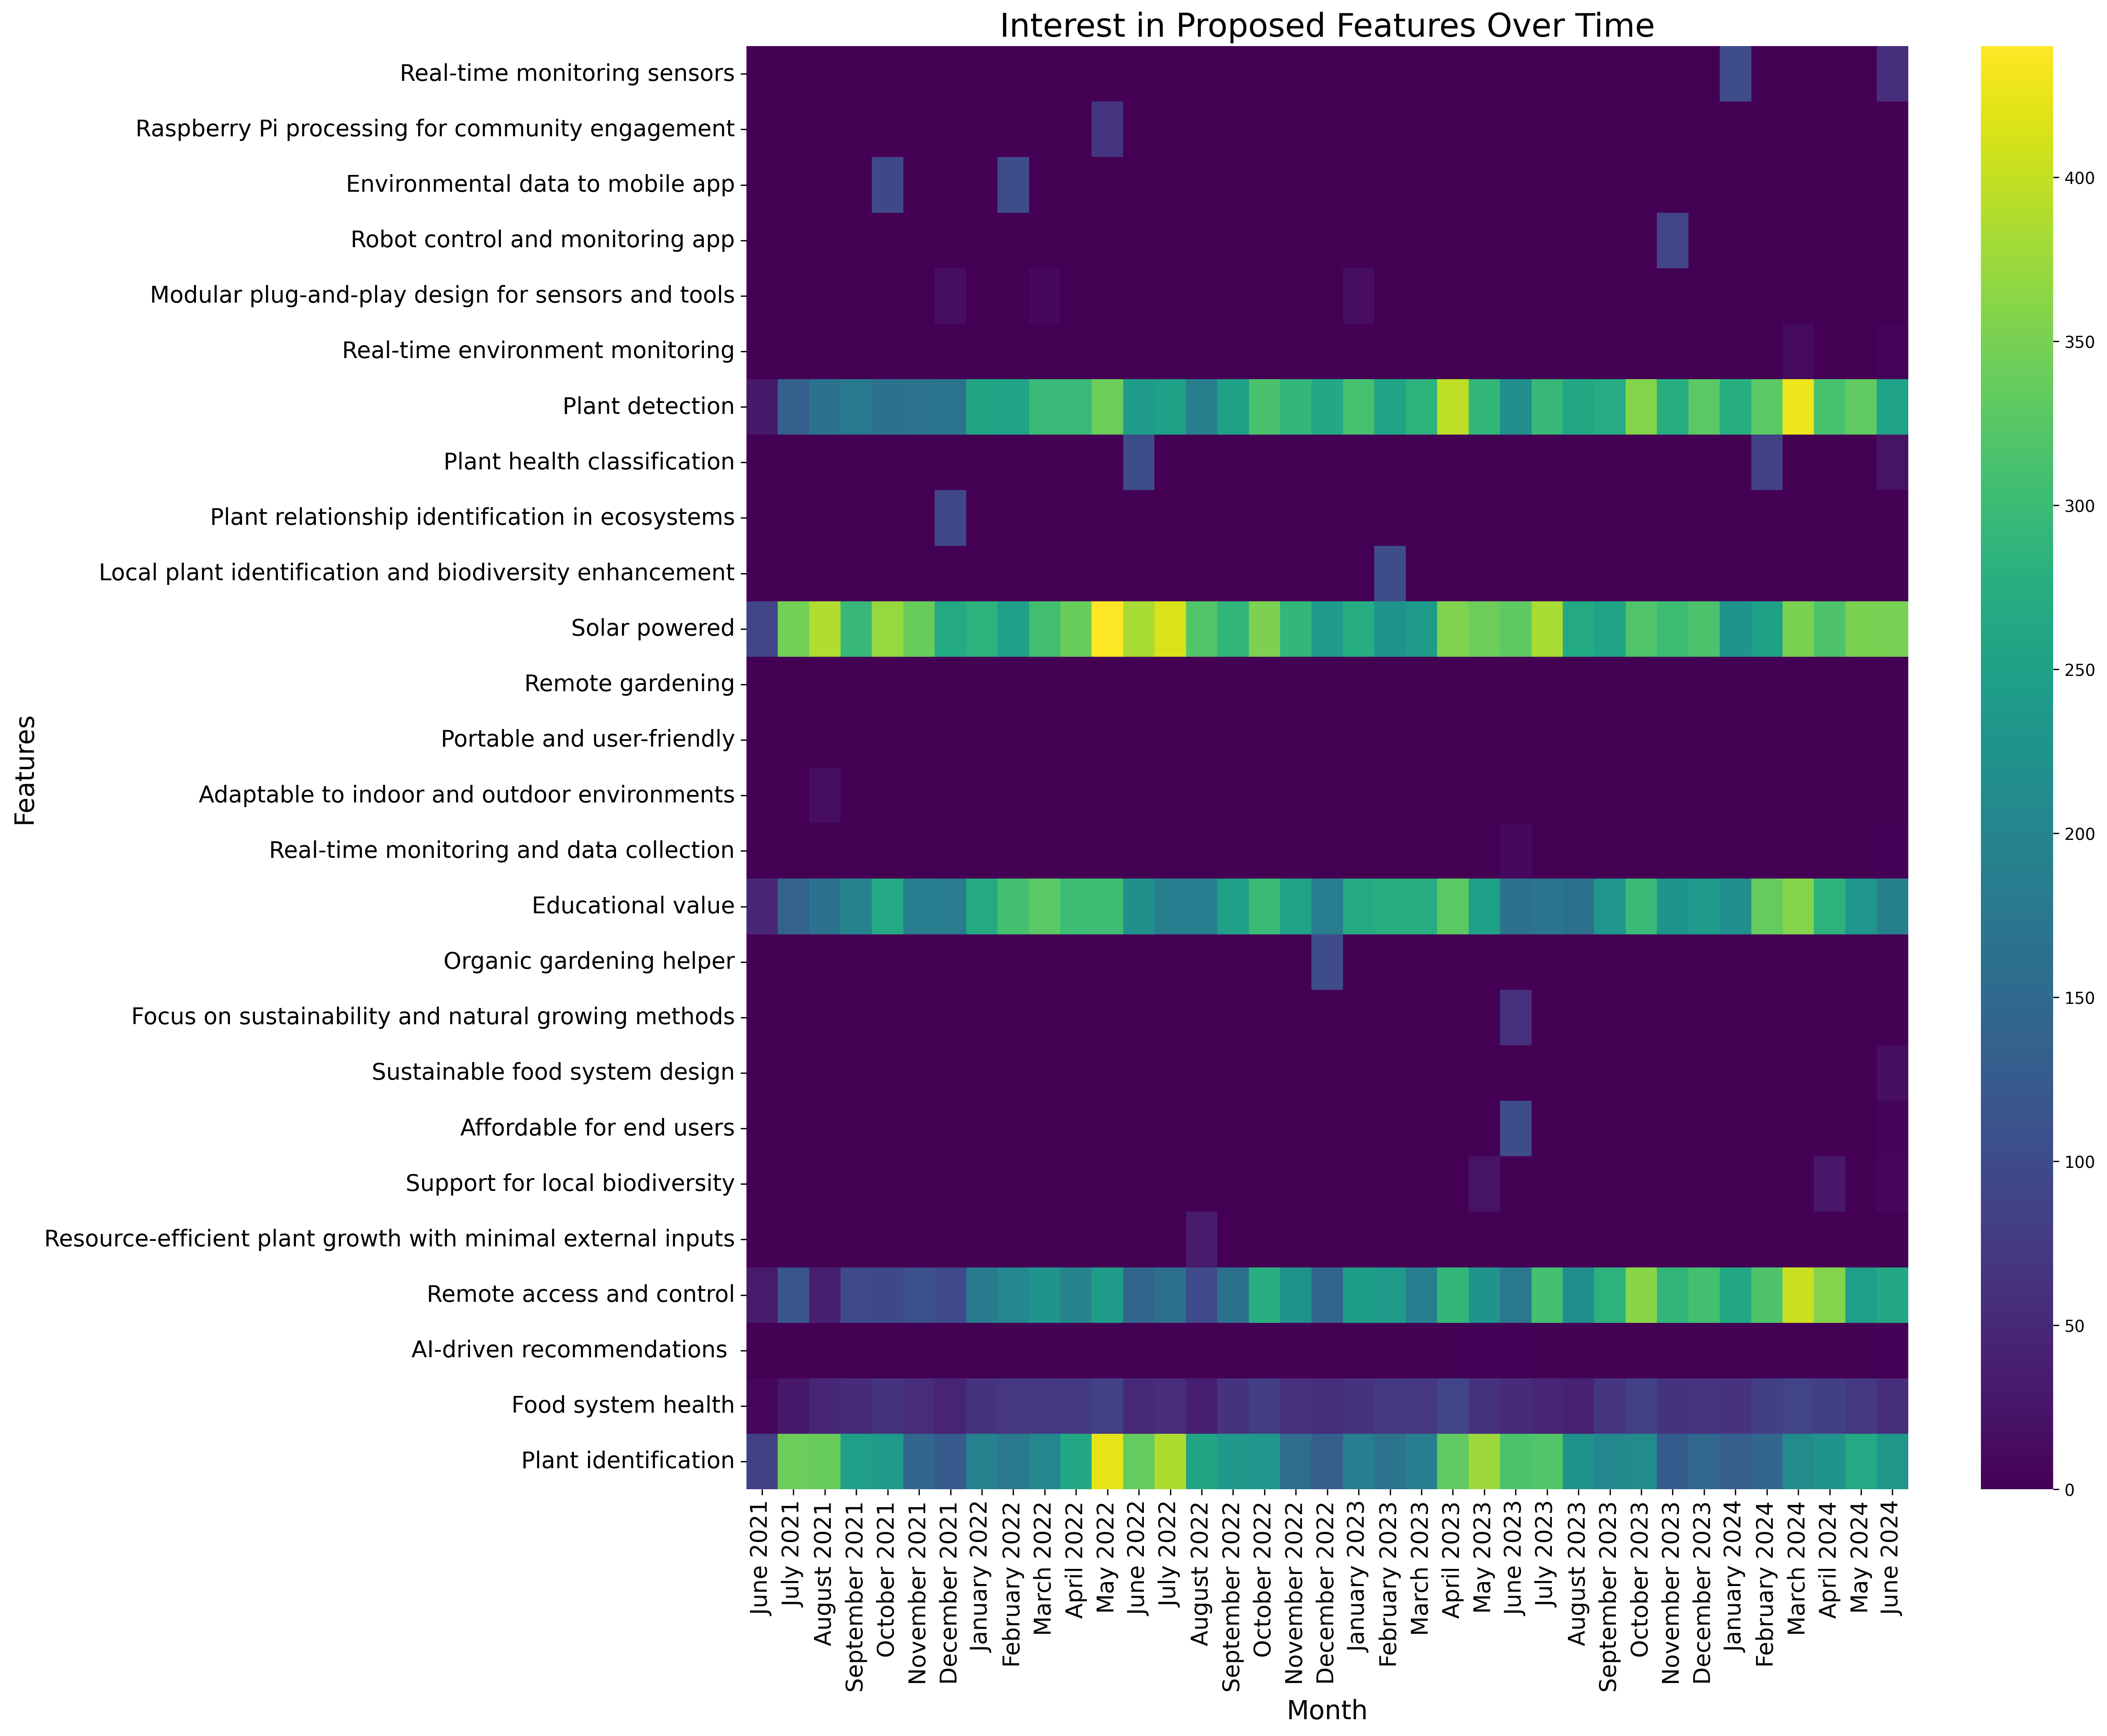

In [152]:
# Create a heatmap to understand how interest changed over time

# Set the figure size and resolution
plt.figure(figsize=(16, 16), dpi=300)

# Create the heatmap plot
sns.heatmap(
    data=features_interest_over_time_monthly.T,
    cmap='viridis', annot=False,
    cbar=True
    )

# Adjust size for x and y axis labels
plt.yticks(fontsize=14)
plt.xticks(fontsize=14);

# Add a title
plt.title('Interest in Proposed Features Over Time', fontsize=20);

# Add labels for the x and y axes
plt.xlabel('Month', fontsize=16)
plt.ylabel('Features', fontsize=16);

### Visualize most relevant features

In [ ]:
# Flatten the dataframe
features_by_interest_flat = features_by_interest.reset_index()
features_by_interest_flat.head()

In [ ]:
# Visualize overall interest in proposed features
plt.figure(figsize=(16, 8), dpi=400)
sns.barplot(data=features_by_interest_flat, x='index', y='interest', hue='index', palette='Set2');
plt.xticks(rotation=90, fontsize=12);

In [ ]:
# Determine weekly average interest
features_by_interest['weekly_average_interest'] = round(features_by_interest['interest'] / 156.42, 3)
features_by_interest.head()

## Explore Relevance of Problems Over Time (interest over time)

### Identify Problems with Highest Relevance
* Calculate the sum of interest values for each problem
* Create a table sorted by relevance (highest interest)

In [106]:
# Calculate the sum of interest values for each problem and sort them by relevance
relevance_problems_interest_over_time = problems_interest_over_time.sum().sort_values(ascending=False)
relevance_problems_interest_over_time.head()

Monoculture in agriculture                               1816
Focus on single crops in agriculture innovation           177
Separation of food production from natural ecosystems     172
Lack of understanding of the natural world                111
Complex setup of automated gardening solutions            100
dtype: int64

In [124]:
# Resample dataframe to show interest in monthly intervals
problems_interest_over_time_monthly = problems_interest_over_time.resample('M').sum()
problems_interest_over_time_monthly.index = problems_interest_over_time_monthly.index.strftime('%B %Y')

# Include only columns with more than 0 total interest
non_zero_columns = problems_interest_over_time_monthly.sum()[problems_interest_over_time_monthly.sum() > 0].index
problems_interest_over_time_monthly = problems_interest_over_time_monthly[non_zero_columns]

problems_interest_over_time_monthly.head()

Monoculture in agriculture  \
date                                         
June 2021                                0   
July 2021                                0   
August 2021                            100   
September 2021                           0   
October 2021                             0   

                Use of preservatives and pesticides in produce  \
date                                                             
June 2021                                                    0   
July 2021                                                    0   
August 2021                                                  0   
September 2021                                             100   
October 2021                                                 0   

                Separation of food production from natural ecosystems  \
date                                                                    
June 2021                                                       0       
July 2021                                                       0       
August 2021                                                     0       
September 2021                                                  0       
October 2021                                                    0       

                Lack of ecosystem integration in automated food production  \
date                                                                         
June 2021                                                       0            
July 2021                                                       0            
August 2021                                                     0            
September 2021                                                  0            
October 2021                                                    0            

                Lack of natural environment in agricultural innovation  \
date                                                                     
June 2021                                                       0        
July 2021                                                       0        
August 2021                                                     0        
September 2021                                                  0        
October 2021                                                    0        

                Limited educational resources in gardening tech  \
date                                                              
June 2021                                                     0   
July 2021                                                     0   
August 2021                                                   0   
September 2021                                                0   
October 2021                                                  0   

                Lack of versatile agricultural robots for indoor and outdoor use  \
date                                                                               
June 2021                                                       0                  
July 2021                                                       0                  
August 2021                                                     0                  
September 2021                                                  0                  
October 2021                                                    0                  

                Lack of understanding of the natural world  \
date                                                         
June 2021                                                0   
July 2021                                                0   
August 2021                                              0   
September 2021                                           0   
October 2021                                             0   

                High costs of automated farming solutions  \
date                                                        
June 2021                           

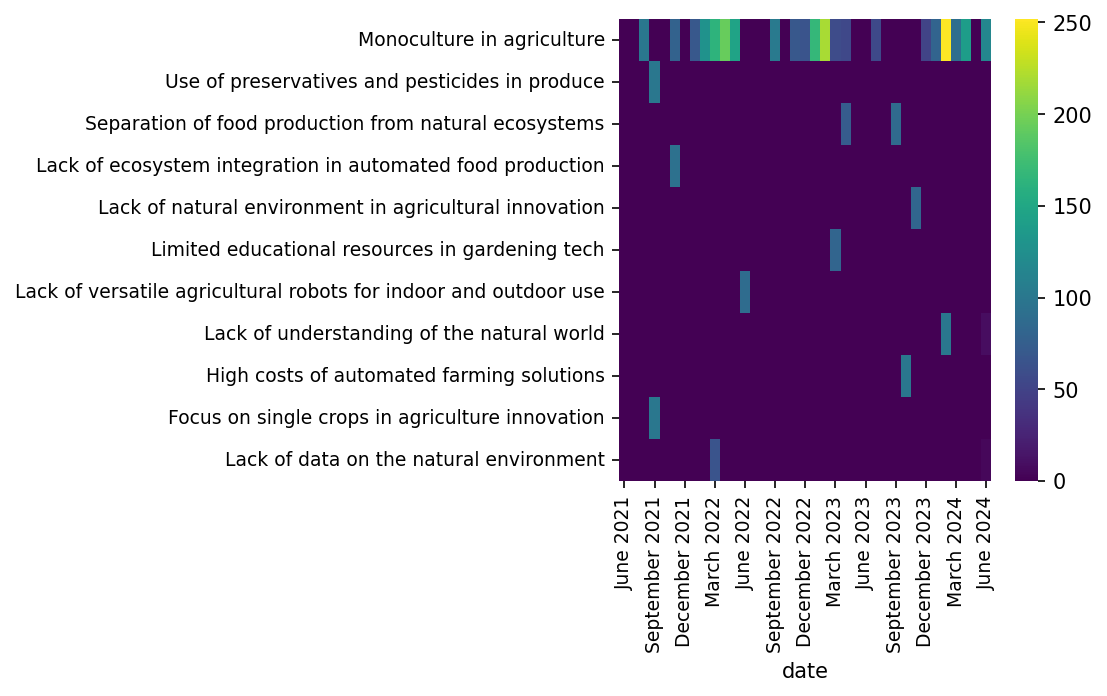

In [ ]:
# Create a heatmap to understand how interest changed over time
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(data=problems_interest_over_time_monthly.T, cmap='viridis', annot=False, cbar=True);
plt.yticks(fontsize=9)
plt.xticks(fontsize=9);

### Visualize how interest in problems increased over time
Determine whether awareness of problems is increasing or decreasing.


In [125]:
# Resample the dataframe to yearly intervals for less noise
problems_interest_over_time_yearly = problems_interest_over_time.resample('Y').sum()
problems_interest_over_time_yearly.index = problems_interest_over_time_yearly.index.strftime('%Y')
problems_interest_over_time_yearly.head()

# Remove columns with only zero values
problems_interest_over_time_yearly = problems_interest_over_time_yearly.loc[:, (problems_interest_over_time_yearly != 0).any()]

In [126]:
# Transform the dataframe so that interest is represented as a colulum
problems_interest_over_time_flat = problems_interest_over_time_yearly.reset_index().melt(id_vars='date', var_name='problem', value_name='interest')
problems_interest_over_time_flat.head()

date                                         problem  interest
0  2021                      Monoculture in agriculture       178
1  2022                      Monoculture in agriculture       934
2  2023                      Monoculture in agriculture       607
3  2024                      Monoculture in agriculture       678
4  2021  Use of preservatives and pesticides in produce       100

In [ ]:
# Visualize interest over time in high relevance problems with more than zero interest
plt.figure(figsize=(16, 8), dpi=400)
sns.lineplot(data=problems_interest_over_time_flat, x='date', y='interest', hue='problem', palette='Set2');
# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12);

# Add title and place legend outside the plot
plt.title('Relevance of Problems over Time')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=14);

In [127]:
# Resample the dataframe to monthly intervals
problems_interest_over_time_monthly = problems_interest_over_time.resample('M').sum()
problems_interest_over_time_monthly.index = problems_interest_over_time_monthly.index.strftime('%Y-%m')
problems_interest_over_time_monthly.head()

Lack of portability in automated farming  \
date                                                
2021-06                                         0   
2021-07                                         0   
2021-08                                         0   
2021-09                                         0   
2021-10                                         0   

         No biological understanding in gardening automation  \
date                                                           
2021-06                                                  0     
2021-07                                                  0     
2021-08                                                  0     
2021-09                                                  0     
2021-10                                                  0     

         Monoculture in agriculture  Long-distance food transport  \
date                                                                
2021-06                           0                             0   
2021-07                           0                             0   
2021-08                         100                             0   
2021-09                           0                             0   
2021-10                           0                             0   

         Disconnect between people and food sources  \
date                                                  
2021-06                                           0   
2021-07                                           0   
2021-08                                           0   
2021-09                                           0   
2021-10                                           0   

         Use of preservatives and pesticides in produce  \
date                                                      
2021-06                                               0   
2021-07                                               0   
2021-08                                               0   
2021-09                                             100   
2021-10                                               0   

         Separation of food production from natural ecosystems  \
date                                                             
2021-06                                                  0       
2021-07                                                  0       
2021-08                                                  0       
2021-09                                                  0       
2021-10                                                  0       

         Lack of ecosystem integration in automated food production  \
date                                                                  
2021-06                                                  0            
2021-07                                                  0            
2021-08                                                  0            
2021-09                                                  0            
2021-10                                                  0            

         Lack of natural environment in agricultural innovation  \
date                                                              
2021-06                                                  0        
2021-07                                                  0        
2021-08                                                  0        
2021-09                                                  0        
2021-10                                                  0        

         Inaccessibility of personal gardening automation  ...  \
date                                                       ...   
2021-06                                                 0  ...   
2021-07                                                 0  ...   
2021-08                                                 0  ...   
2021-09                                                 0  ...   
2021-10                                                 0  ...   

         L

In [128]:
# Remove columns with only zero values
problems_interest_over_time_monthly = problems_interest_over_time_monthly.loc[:, (problems_interest_over_time_monthly != 0).any()]
problems_interest_over_time_monthly.head()

Monoculture in agriculture  \
date                                  
2021-06                           0   
2021-07                           0   
2021-08                         100   
2021-09                           0   
2021-10                           0   

         Use of preservatives and pesticides in produce  \
date                                                      
2021-06                                               0   
2021-07                                               0   
2021-08                                               0   
2021-09                                             100   
2021-10                                               0   

         Separation of food production from natural ecosystems  \
date                                                             
2021-06                                                  0       
2021-07                                                  0       
2021-08                                                  0       
2021-09                                                  0       
2021-10                                                  0       

         Lack of ecosystem integration in automated food production  \
date                                                                  
2021-06                                                  0            
2021-07                                                  0            
2021-08                                                  0            
2021-09                                                  0            
2021-10                                                  0            

         Lack of natural environment in agricultural innovation  \
date                                                              
2021-06                                                  0        
2021-07                                                  0        
2021-08                                                  0        
2021-09                                                  0        
2021-10                                                  0        

         Limited educational resources in gardening tech  \
date                                                       
2021-06                                                0   
2021-07                                                0   
2021-08                                                0   
2021-09                                                0   
2021-10                                                0   

         Lack of versatile agricultural robots for indoor and outdoor use  \
date                                                                        
2021-06                                                  0                  
2021-07                                                  0                  
2021-08                                                  0                  
2021-09                                                  0                  
2021-10                                                  0                  

         Lack of understanding of the natural world  \
date                                                  
2021-06                                           0   
2021-07                                           0   
2021-08                                           0   
2021-09                                           0   
2021-10                                           0   

         High costs of automated farming solutions  \
date                                                 
2021-06                                          0   
2021-07                                          0   
2021-08                                          0   
2021-09                                          0   
2021-10                                          0   

         Focus on single crops in agriculture innovation  \
date                                                       
2021-06                                     

In [129]:
# Transform the dataframe to long format
problems_interest_over_time_monthly_flat = problems_interest_over_time_monthly.reset_index().melt(id_vars='date', var_name='problem', value_name='interest')
problems_interest_over_time_monthly_flat.head()

date                     problem  interest
0  2021-06  Monoculture in agriculture         0
1  2021-07  Monoculture in agriculture         0
2  2021-08  Monoculture in agriculture       100
3  2021-09  Monoculture in agriculture         0
4  2021-10  Monoculture in agriculture         0

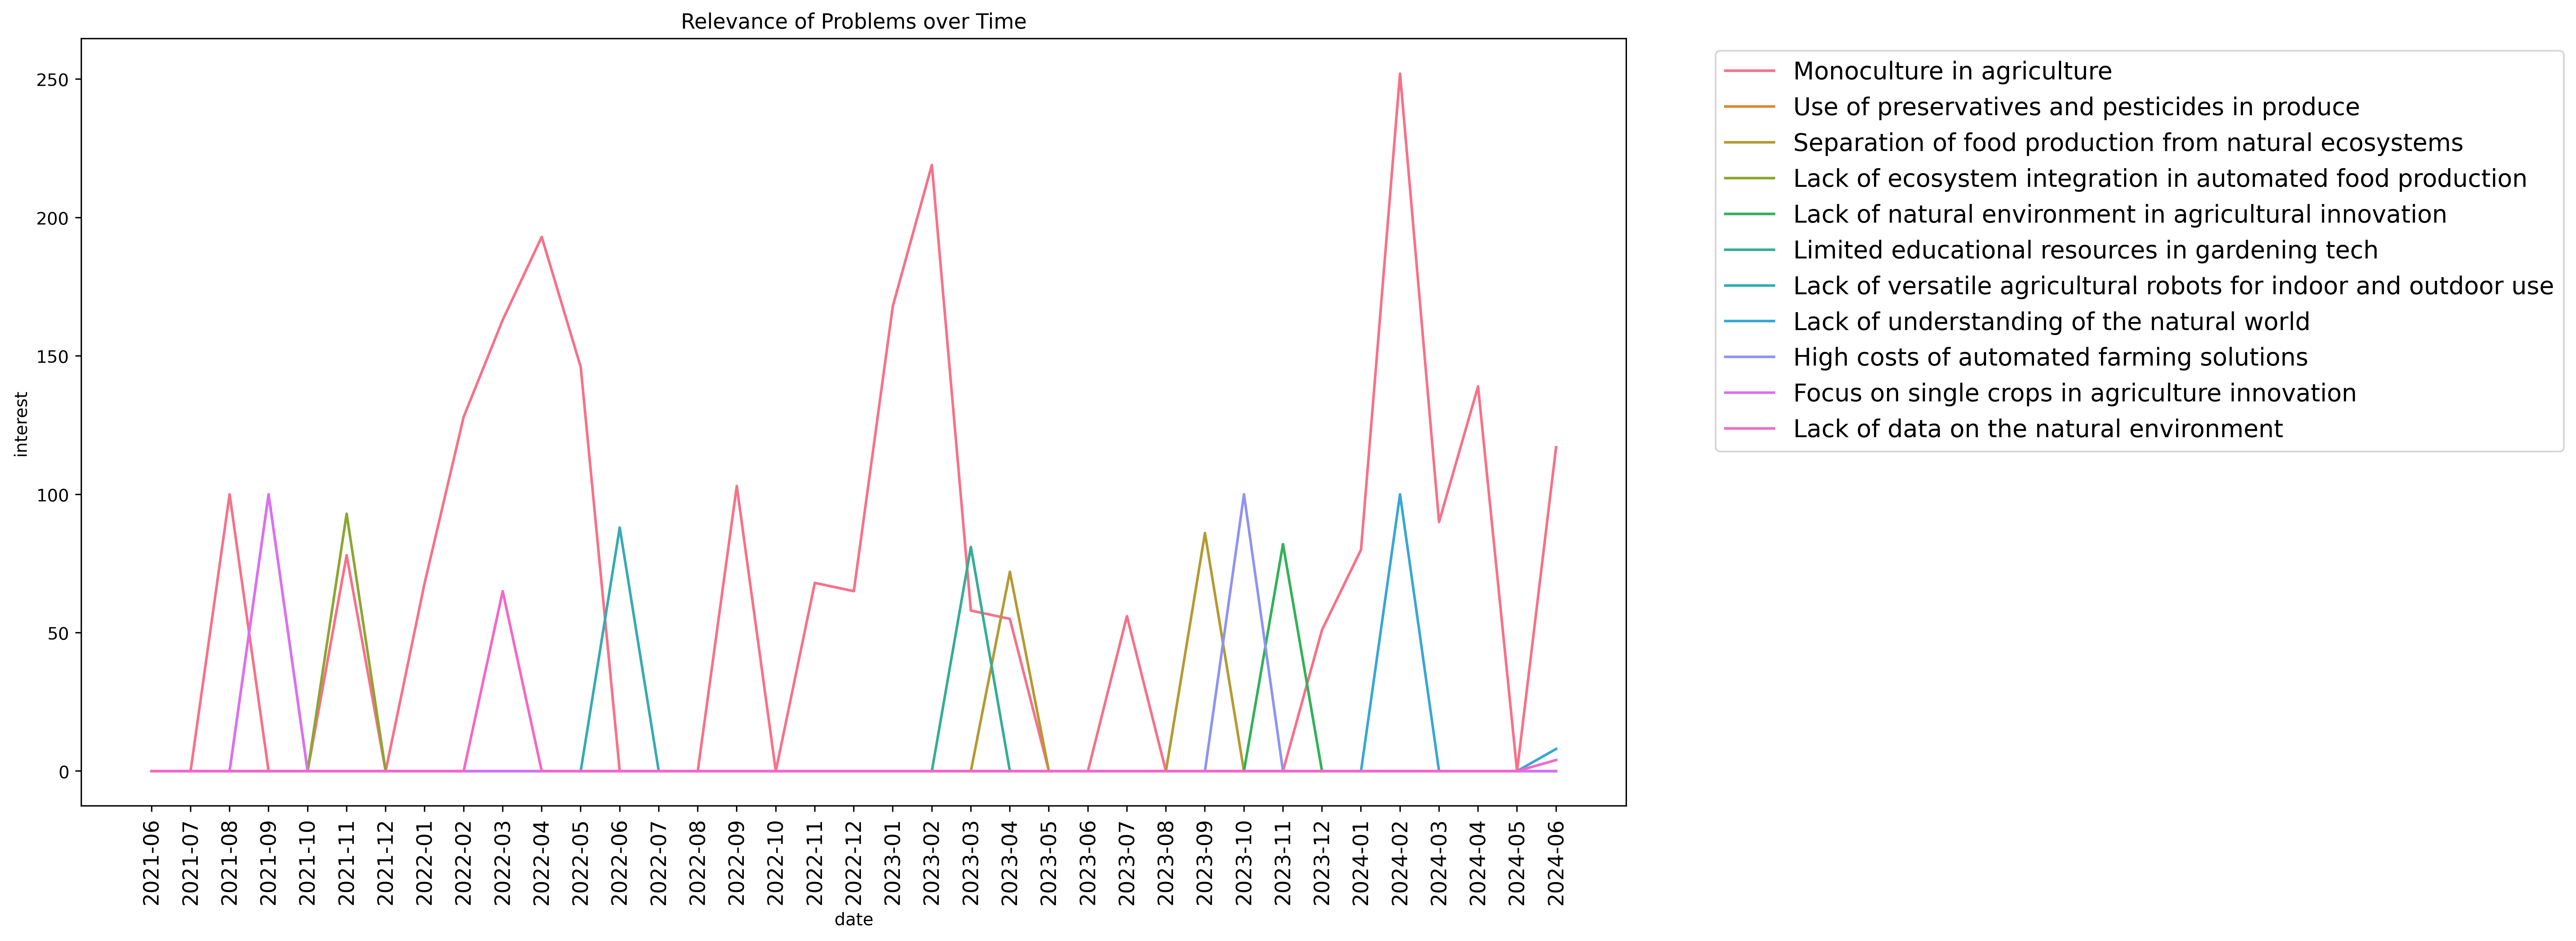

In [ ]:
# Plot the same monthly for more granularity
plt.figure(figsize=(16, 8), dpi=400)
sns.lineplot(data=problems_interest_over_time_monthly_flat, x='date', y='interest', hue='problem', palette='husl');
# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12);

# Add title and place legend outside the plot
plt.title('Relevance of Problems over Time')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=14);


In [ ]:
# Get weekly average interest for the problems
problems_by_relevance = pd.DataFrame(problems_by_relevance, columns=['interest'])
problems_by_relevance.head()
problems_by_relevance['weekly_average_interest'] = round(problems_by_relevance['interest'] / 156.42, 3)
problems_by_relevance.head()

interest  \
Monoculture in agriculture                              2397   
Separation of food production from natural ecos...       158   
Lack of understanding of the natural world               108   
High costs of automated farming solutions                100   
Focus on single crops in agriculture innovation          100   

                                                    weekly_average_interest  
Monoculture in agriculture                                           15.324  
Separation of food production from natural ecos...                    1.010  
Lack of understanding of the natural world                            0.690  
High costs of automated farming solutions                             0.639  
Focus on single crops in agriculture innovation                       0.639

In [ ]:
# Rename columns
problems_by_relevance.rename(columns={'weekly_average_interest': 'problems_weekly_average_interest'}, inplace=True)
features_by_interest.rename(columns={'weekly_average_interest': 'features_weekly_average_interest'}, inplace=True)

# Create a new dataframe with weekly average interest in features and problems as columns
features_problems_interest = pd.concat([problems_by_relevance['problems_weekly_average_interest'], features_by_interest['features_weekly_average_interest']], axis=1)
features_problems_interest.head()

problems_weekly_average_interest  \
Monoculture in agriculture                                                    15.324   
Separation of food production from natural ecos...                             1.010   
Lack of understanding of the natural world                                     0.690   
High costs of automated farming solutions                                      0.639   
Focus on single crops in agriculture innovation                                0.639   

                                                    features_weekly_average_interest  
Monoculture in agriculture                                                       NaN  
Separation of food production from natural ecos...                               NaN  
Lack of understanding of the natural world                                       NaN  
High costs of automated farming solutions                                        NaN  
Focus on single crops in agriculture innovation                                  NaN

## Explore relevance (interest over time) in needs addressed

### Identify Problems with Highest Relevance
* Calculate the sum of interest values for each problem
* Create a table sorted by relevance (highest interest)

In [ ]:
# Sort needs by relevance
relevance_needs_interest_over_time = needs_interest_over_time.sum().sort_values(ascending=False)
relevance_needs_interest_over_time.head()

In [ ]:
# Resample the dataframe to show interest in monthly intervals
needs_interest_over_time_monthly = needs_interest_over_time.resample('M').sum()
needs_interest_over_time_monthly.index = needs_interest_over_time_monthly.index.strftime('%B %Y')
needs_interest_over_time_monthly.tail()

Sustainable food production  Educational AI  \
date                                                         
February 2024                          158             340   
March 2024                             184             429   
April 2024                             158             363   
May 2024                               142             332   
June 2024                              100             291   

               User-friendly gardening automation  \
date                                                
February 2024                                   0   
March 2024                                      0   
April 2024                                      0   
May 2024                                        0   
June 2024                                       0   

               Versatile farming solutions for different environments  \
date                                                                    
February 2024                                                  0        
March 2024                                                     0        
April 2024                                                     0        
May 2024                                                       0        
June 2024                                                      0        

               Ecosystem-aware agricultural technology  \
date                                                     
February 2024                                        0   
March 2024                                           0   
April 2024                                          88   
May 2024                                             0   
June 2024                                            0   

               Bridge gap between humans and nature  \
date                                                  
February 2024                                     0   
March 2024                                        0   
April 2024                                        0   
May 2024                                          0   
June 2024                                         0   

               Minimize environmental impact with local food  \
date                                                           
February 2024                                              0   
March 2024                                                 0   
April 2024                                                 0   
May 2024                                                   0   
June 2024                                                  0   

               Real-time feedback on ecosystem health  \
date                                                    
February 2024                                       0   
March 2024                                          0   
April 2024                                          0   
May 2024                                            0   
June 2024                                           0   

               Utilize local biodiversity for food systems  \
date                                                         
February 2024                                            0   
March 2024                                              67   
April 2024                                               0   
May 2024                                                 0   
June 2024                                                0   

               Access and interpret environmental data  \
date                                                     
February 2024                                        0   
March 2024                                           0   
April 2024                                           0   
May 2024                                            82   
June 2024                                            0   

               Reduce food waste with optimized conditions  \
date                                                         
February 2024                                            0   
March 2024                

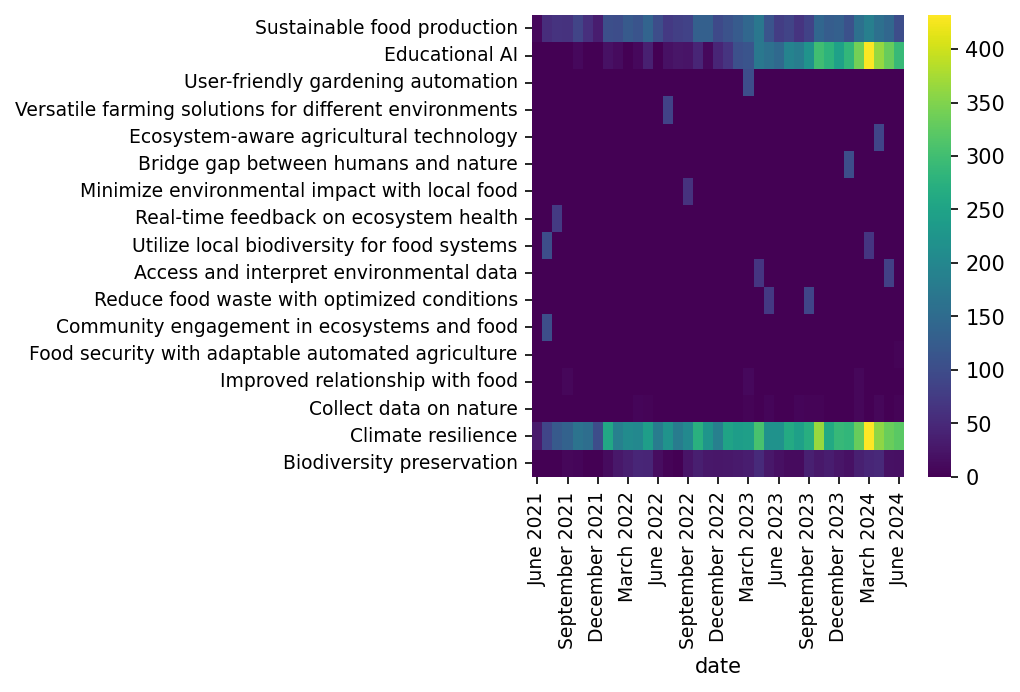

In [ ]:
# Create a heatmap to understand how interest changed over time
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(data=needs_interest_over_time_monthly.T, cmap='viridis', annot=False, cbar=True);
plt.yticks(fontsize=9)
plt.xticks(fontsize=9);

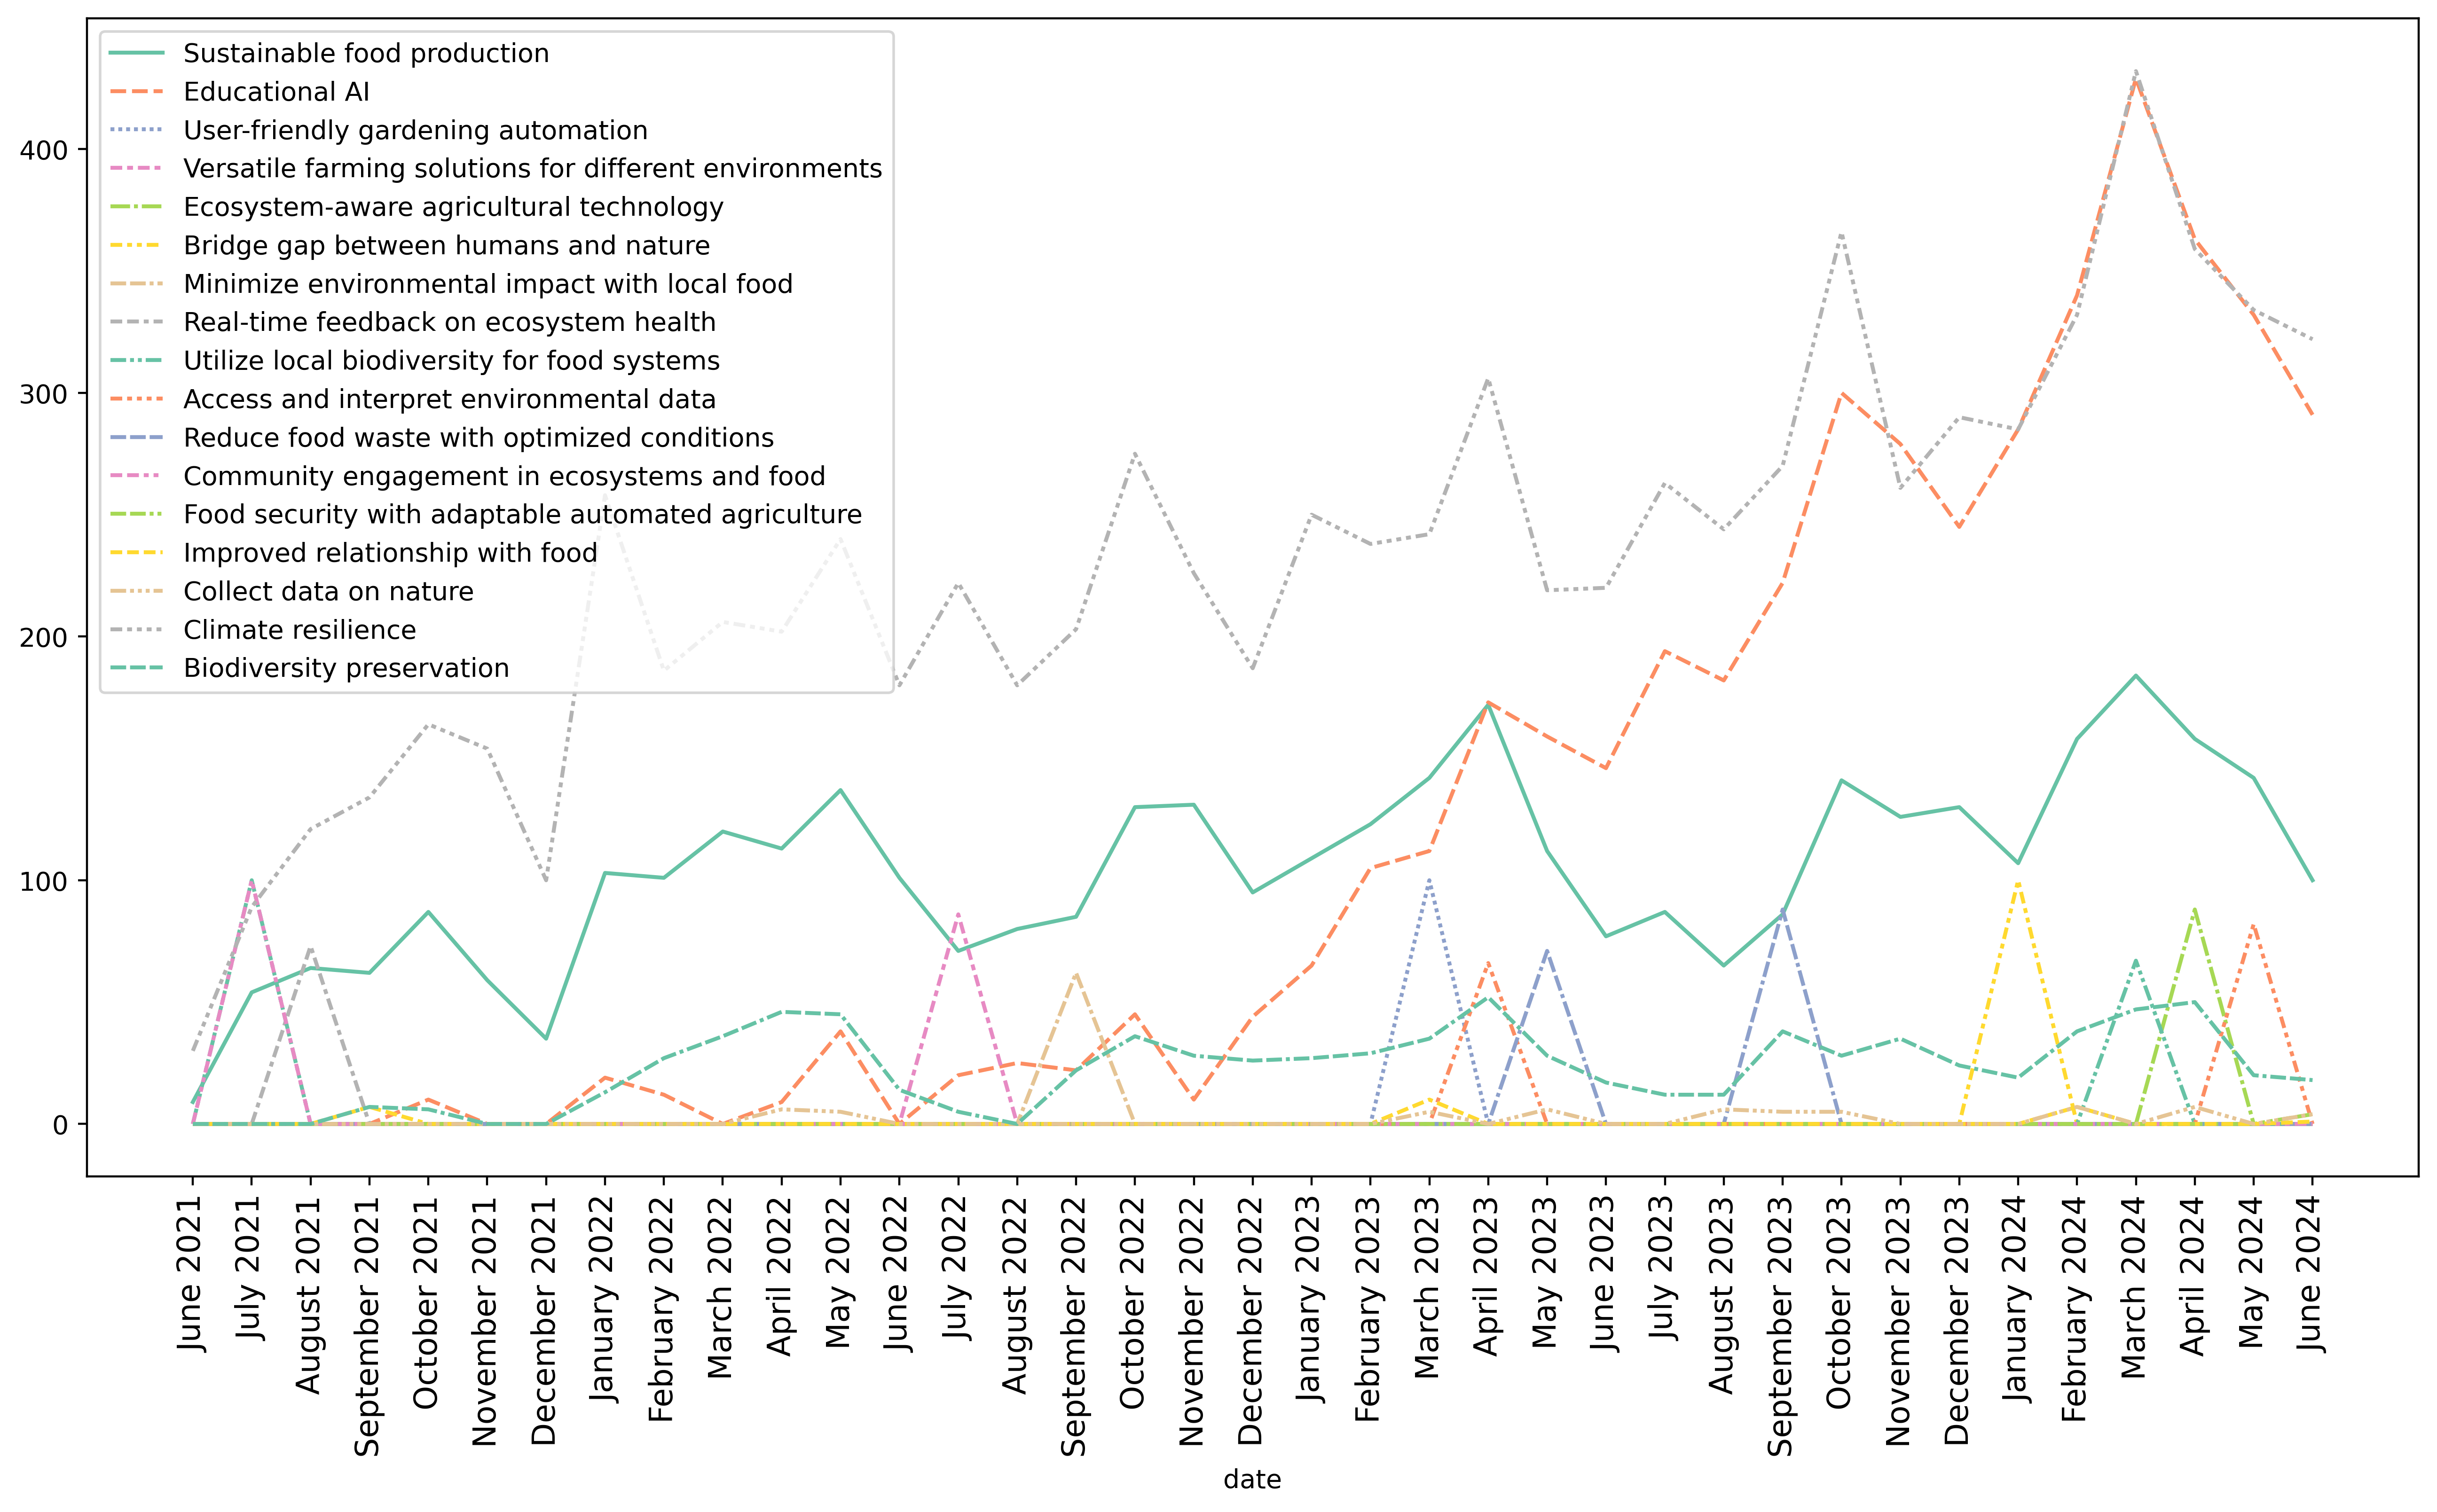

In [ ]:
# Visualize the overall relevance of needs over the last 3 years
plt.figure(figsize=(16, 8), dpi=400)
sns.lineplot(data=needs_interest_over_time_monthly, palette='Set2');
plt.xticks(rotation=90, fontsize=12);

### Visualize overall relevance of needs in comparison to one another
Determine which needs were the most relevant over the last three years.

In [ ]:
# Flatten the dataframe
needs_by_relevance_flat = needs_by_relevance.reset_index()
needs_by_relevance_flat.columns.values[1] = 'interest'
needs_by_relevance_flat.head()

index  interest
0                           Climate resilience      8590
1                               Educational AI      4476
2                  Sustainable food production      3856
3                    Biodiversity preservation       840
4  Utilize local biodiversity for food systems       167

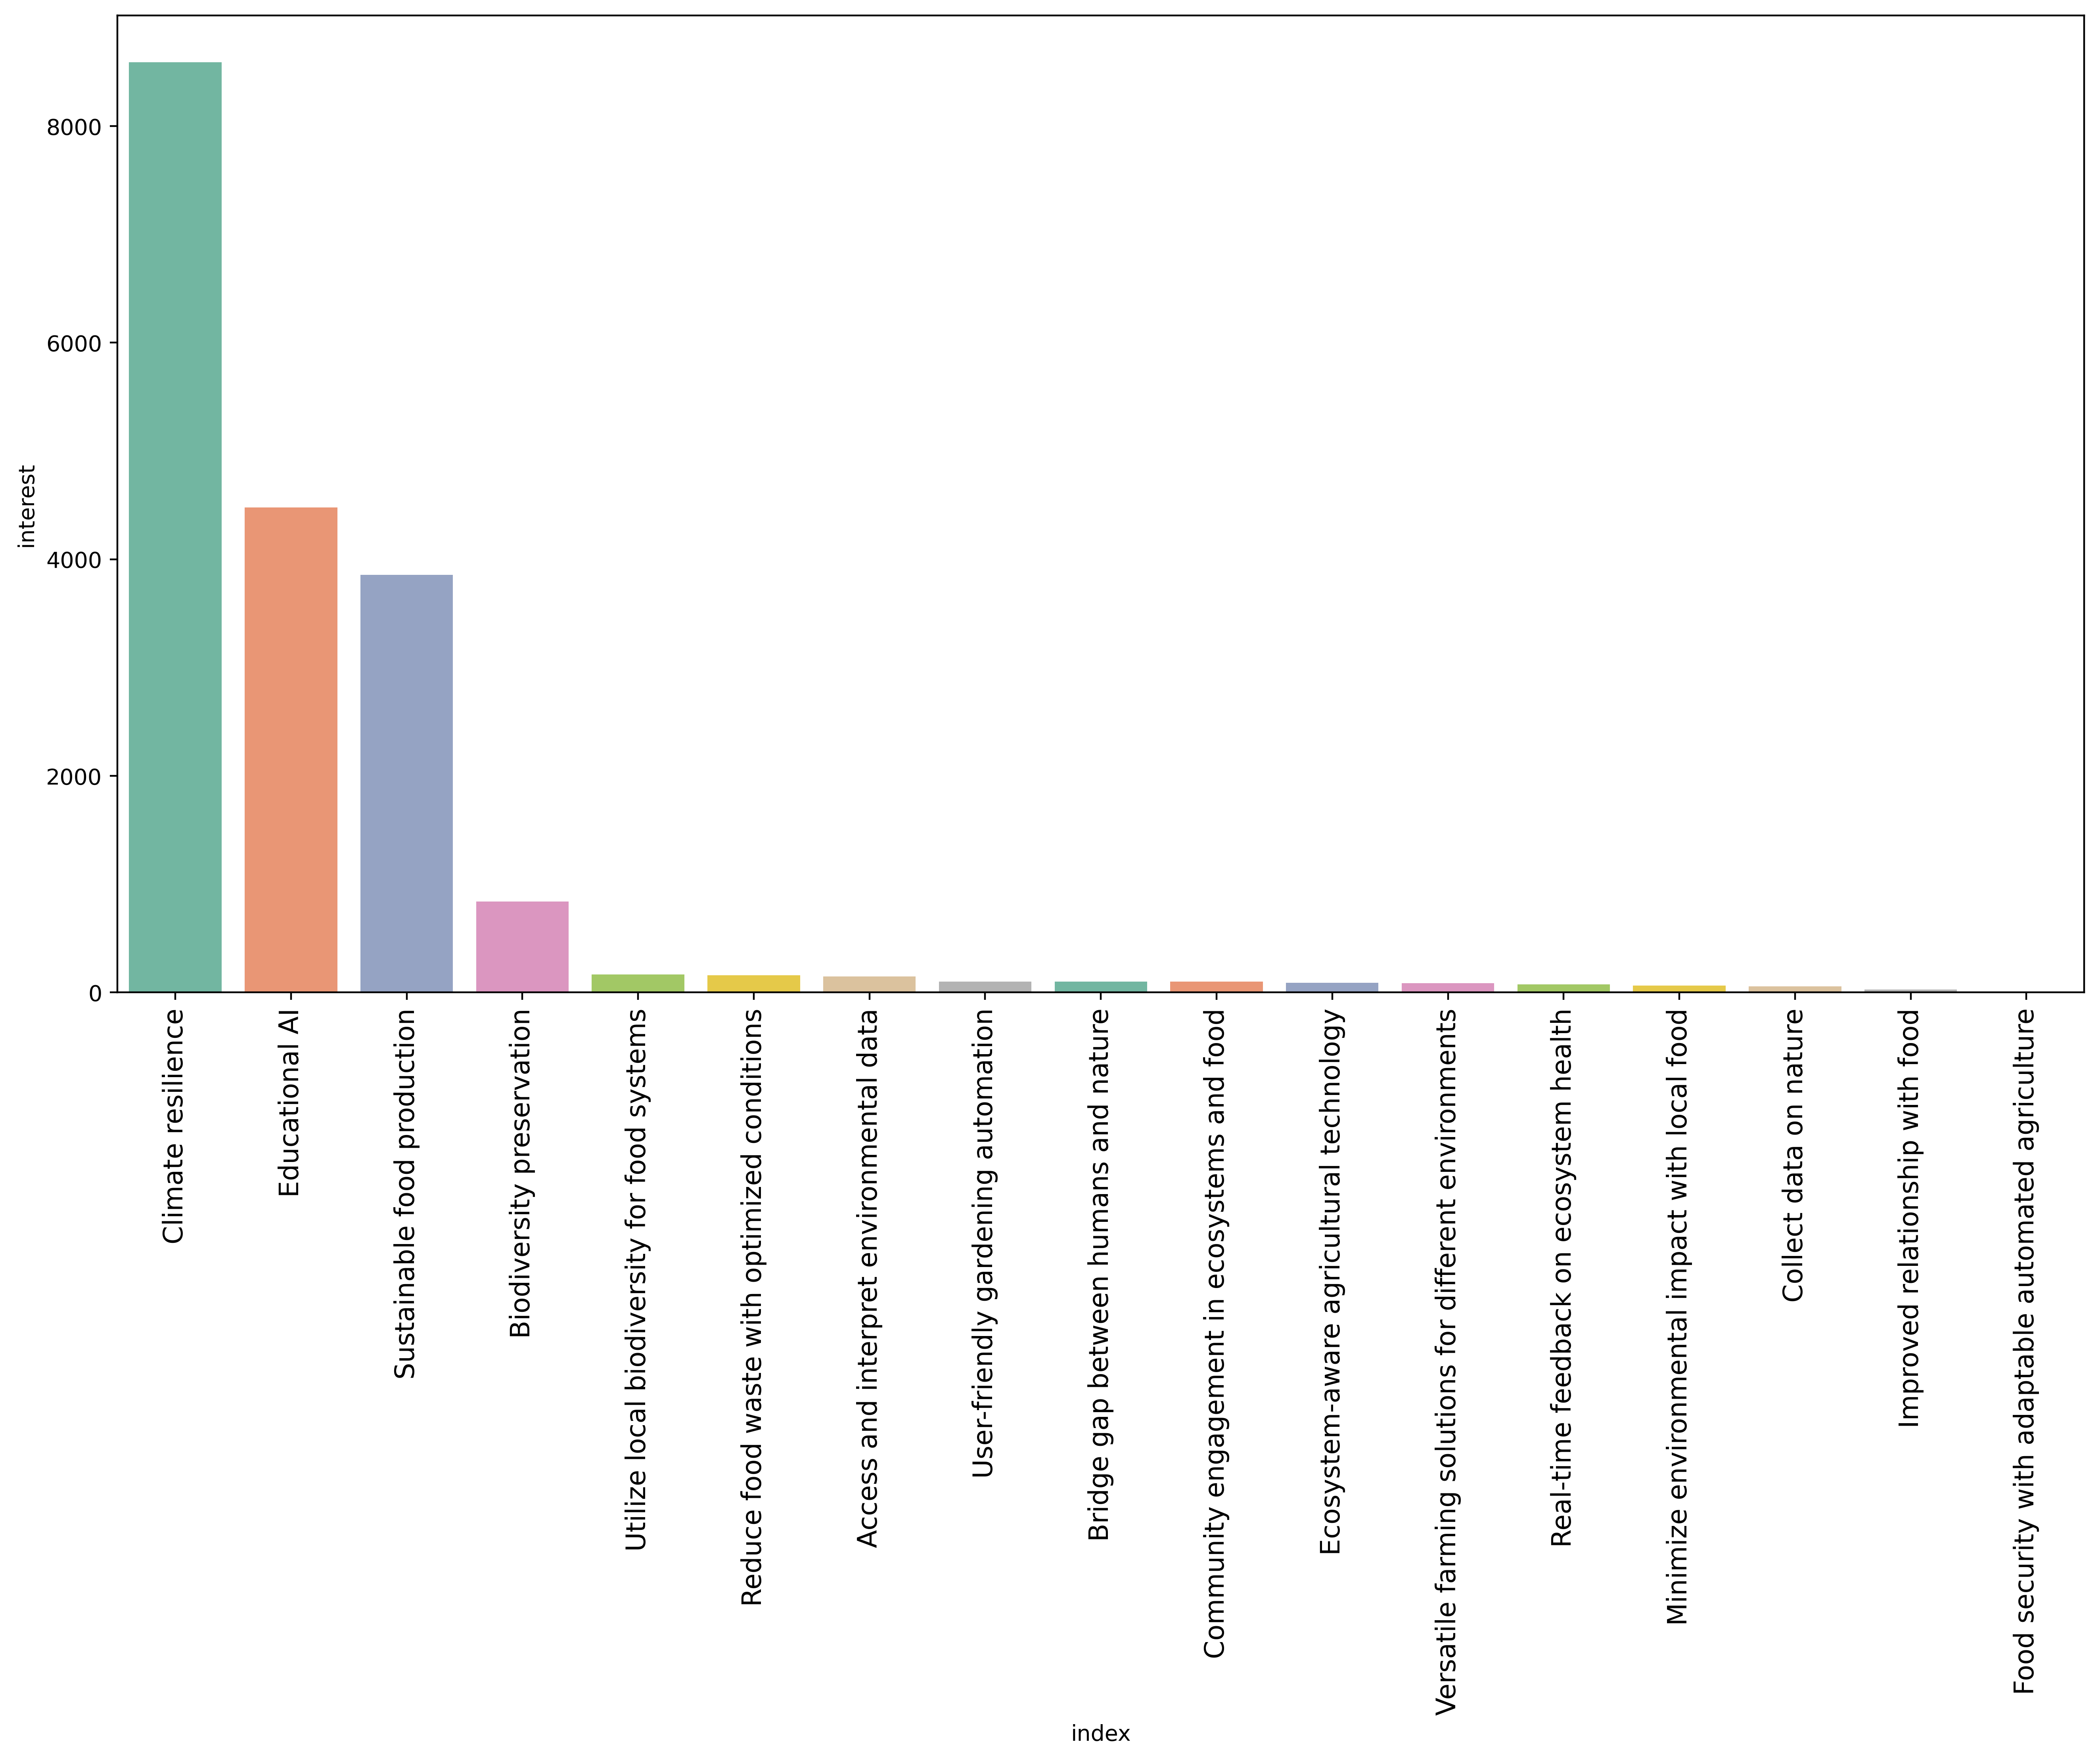

In [ ]:
# Visualize relevance of needs in comparison using a bar chart
plt.figure(figsize=(16, 8), dpi=400)
sns.barplot(data=needs_by_relevance_flat, x='index', y='interest', hue='index', palette='Set2');
plt.xticks(rotation=90, fontsize=12);

## Visualize how interest in needs differs from from interest in features and interest in problems
* Which needs,problems or features have the overall highest interest?
* Compare the weekly average of all keywords searched


In [ ]:
# Get weekly average interest in features and create a new dataframe
features_by_interest['weekly_average_interest'] = round(features_by_interest['interest'] / 156.42, 3)
features_by_interest.head()

interest  weekly_average_interest
Solar powered                 11745                   75.086
Plant detection               10079                   64.435
Educational value              8770                   56.067
Plant identification           8530                   54.533
Remote access and control      7605                   48.619

In [131]:
# Get average monthly interest for problems and create a new dataframe
problems_by_relevance = pd.DataFrame(problems_by_relevance, columns=['interest'])
problems_by_relevance.head()
problems_by_relevance['weekly_average_interest'] = round(problems_by_relevance['interest'] / 156.42, 3)
problems_by_relevance.head()

interest  \
Monoculture in agriculture                              2397   
Separation of food production from natural ecos...       158   
Lack of understanding of the natural world               108   
High costs of automated farming solutions                100   
Focus on single crops in agriculture innovation          100   

                                                    weekly_average_interest  
Monoculture in agriculture                                           15.324  
Separation of food production from natural ecos...                    1.010  
Lack of understanding of the natural world                            0.690  
High costs of automated farming solutions                             0.639  
Focus on single crops in agriculture innovation                       0.639

In [49]:
# Get average monthly interest in needs and create a new dataframe
needs_by_relevance = pd.DataFrame(needs_by_relevance, columns=['interest'])
needs_by_relevance['weekly_average_interest'] = round(needs_by_relevance['interest'] / 156.42, 3)
needs_by_relevance.head()

interest  weekly_average_interest
Climate resilience                 8776                   56.105
Educational AI                     4612                   29.485
Sustainable food production        3989                   25.502
Biodiversity preservation           877                    5.607
Robotics for Ecosystem Health       279                    1.784

In [97]:
# Create a dataframe with weekly average interest in all keywords

# Reset the index and create a keyword column for all dataframes
features_by_interest_flat = features_by_interest.reset_index()
problems_by_relevance_flat = problems_by_relevance.reset_index()
needs_by_relevance_flat = needs_by_relevance.reset_index()

# Concatenate as rows to a new dataframe
all_keywords = pd.concat([features_by_interest_flat, problems_by_relevance_flat, needs_by_relevance_flat], axis=0)
all_keywords.rename(columns={'index': 'keyword'}, inplace=True)
all_keywords.head()

# Sort the dataframe by weekly average interest
all_keywords = all_keywords.sort_values(by='weekly_average_interest', ascending=False)
all_keywords.tail()


keyword  interest  \
22  AI-driven recommendations for food system health         3   
28          Real-time monitoring and data collection         2   
27             Food system input and output tracking         2   
26               AI-driven gardening recommendations         2   
29                        Portable and user-friendly         1   

    weekly_average_interest  
22                    0.019  
28                    0.013  
27                    0.013  
26                    0.013  
29                    0.006

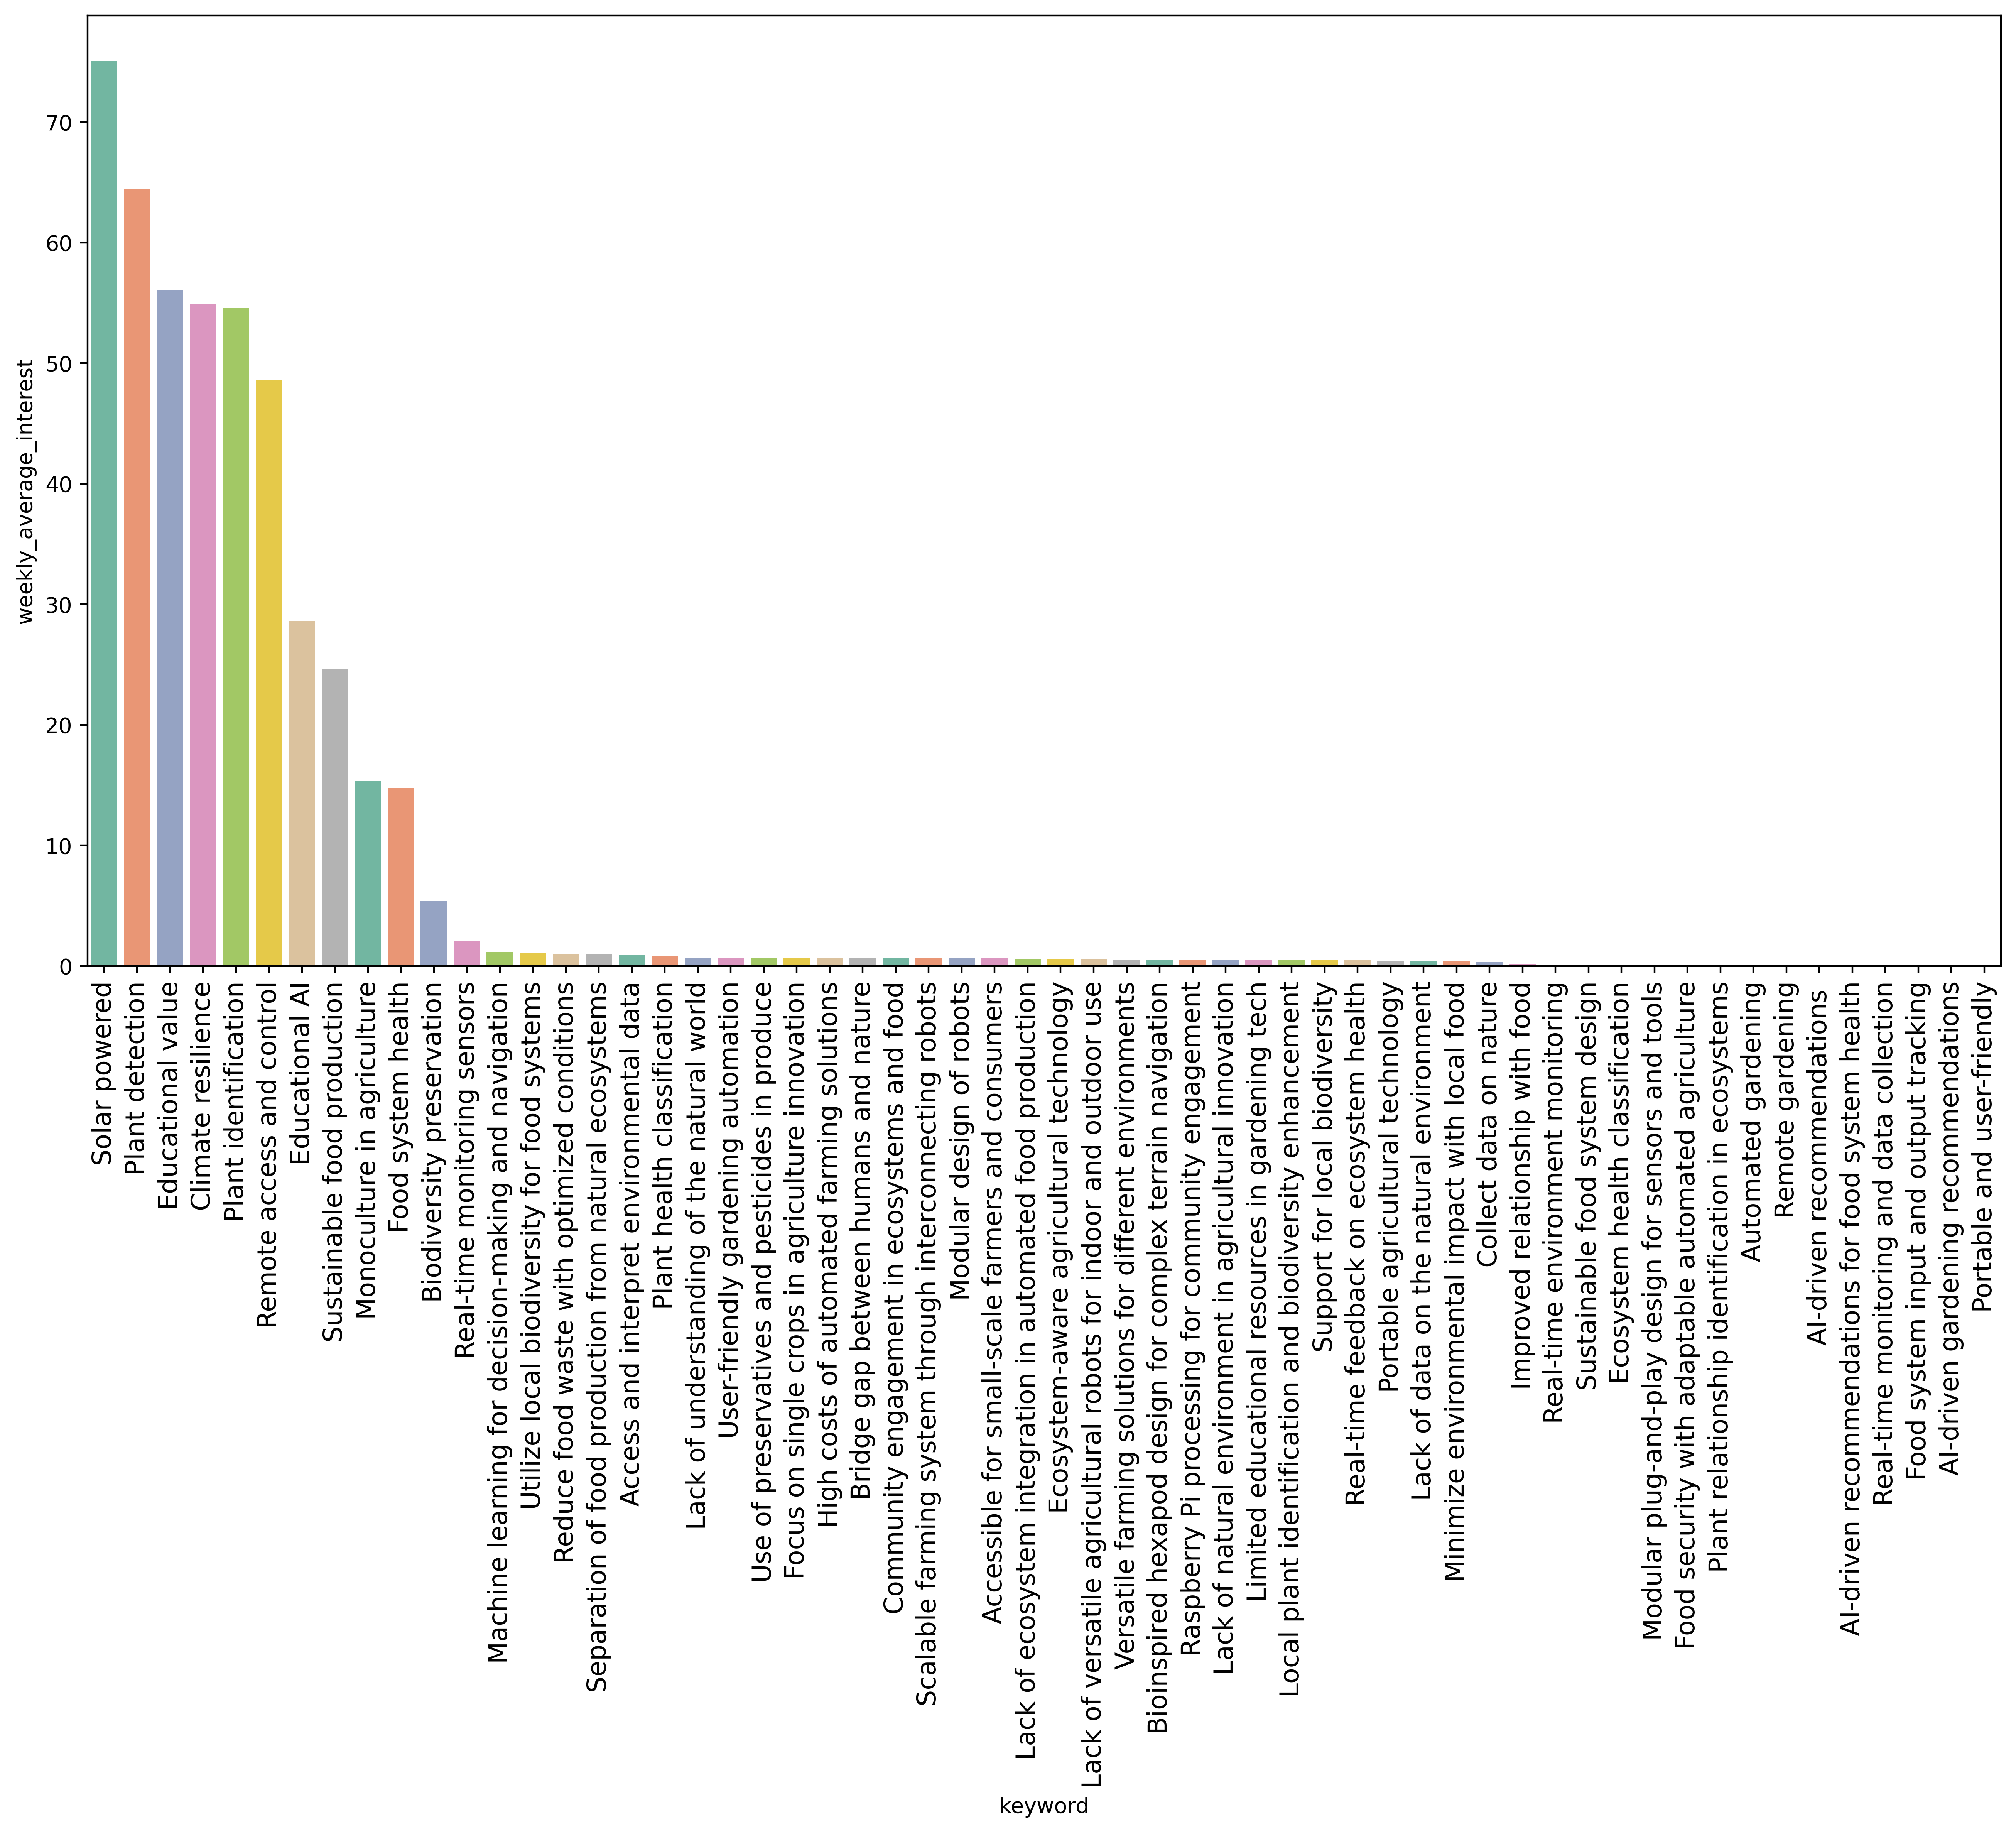

In [98]:
# Visualize weekly average interest in all keywords
plt.figure(figsize=(16, 8), dpi=400)
sns.barplot(data=all_keywords, x='keyword', y='weekly_average_interest', hue='keyword', palette='Set2');
plt.xticks(rotation=90, fontsize=12);

<a name='evaluate-and-select-relevant-data'></a>
# Evaluate and Select Relevant Data
* Evaluate the explored data and decide which parts are valuable for further analysis



## Evaluate Relevant Data on Interest in Features
* **Weekly interest in features**: Valuable as this data provides easy-to-understand metrics (0 - 100) and offers insights into which prototype features are most relevant out of the ones that received interest.
* **Interest in featues over time**: Relevant for analyzing how interest in features changes over time. Includes features with zero interest.
* **Zero interest features**: Need further evaluation to understand why these keywords received no interest.

## Storage Plan on Interest in Features
1. **Features by Average Weekly Interest**:
  * Dataframe: `features_by_interest`
  * Description: Contains the average weekly interest for each relevant feature keyword
  * Reason: Provides a metric for comparing the relevance of features to customers
  * File name: `features_by_interest.parquet`
2. **Interest in Features Over Time**:
  * Dataframe: `features_interest_over_time`
  * Description: Contains weekly interest in features over a period of 3 years. Contains features with zero interest.
  * Reason: Helps understanding trends and changes in interest over time.
  File name: `features_interest_over_time.parquet`
3. **Features with Zero Interest**:
  * Dataframe: `zero_interest_features`
  * Description: Contains keywords from the feature list that returned zero interest.
  * Reason: To determine whether the lack of interest is due to the keywords used or the features themselves.
  * File name: `zero_interest_features.parquet`

## Evaluate Relevant Data on Interest in Problems (relevance of problems)
* **Weekly interest in problems**: Valuable as this data provides easy-to-understand metrics (0 - 100) and offers insights into which problems the prototype aims to address are most relevant out of the ones that received interest.
* **Interest in problems over time**: Relevant for analyzing how the relevance of problems changes over time. Includes problems with zero interest.
* **Zero interest problems**: Need further evaluation to understand why these keywords received no interest.

## Storage Plan on Interest in Problems
1. **Problems by Average Weekly Interest**:
  * Dataframe: `problems_by_relevance`
  * Description: Contains the average weekly interest for each relevant problem keyword
  * Reason: Provides a metric for comparing the relevance of problems to customers
  * File name: `problems_by_relevance.parquet`
2. **Relevance of Problems Over Time**:
  * Dataframe: `problems_relevance_over_time`
  * Description: Contains weekly interest in features over a period of 3 years. Contains features with zero interest.
  * Reason: Helps understanding trends and changes in interest over time.
  File name: `problems_relevance_over_time.parquet`
3. **Problems with Zero Relevance**:
  * Dataframe: `zero_relevance_problems`
  * Description: Contains keywords from the problems list that returned zero interest.
  * Reason: To determine whether the lack of interest is due to the keywords used or the problems themselves.
  * File name: `zero_relevance_problems.parquet`

## Evaluate Relevant Data on Interest in Needs (relevance of needs)
* **Weekly interest in Needs**: Valuable as this data provides easy-to-understand metrics (0 - 100) and offers insights into which needs the prototype aims to address are most relevant out of the ones that received interest.
* **Interest in Needs Over Time**: Useful for analyzing how the relevance of needs changes over time. Includes needs with zero interest.
* **Zero Interest Needs**: Needs further evaluation to understand why these keywords received no interest.

## Storage Plan on Interest in Needs
1. **Needs by Average Weekly Interest**:
  * Dataframe: `needs_by_relevance`
  * Description: Contains the average weekly interest for each relevant need keyword
  * Reason: Provides a metric for comparing the relevance of needs to customers
  * File name: `needs_by_relevance.parquet`
2. **Relevance of Need Over Time**:
  * Dataframe: `needs_interest_over_time_all`
  * Description: Contains weekly relevance of needs over a period of 3 years. Includes needs with zero interest.
  * Reason: Helps understanding trends and changes in interest over time.
  File name: `needs_interest_over_time.parquet`
3. **Needs with Zero Relevance**:
  * Dataframe: `zero_relevance_needs`
  * Description: Contains keywords in the needs list that returned zero interest.
  * Reason: To determine whether the lack of interest is due to the keywords used or the needs themselves.
  * File name: `zero_relevance_needs.parquet`

<a name='store-data-in-gcs'></a>
# Store Data in GCS
* Store cleaned and transformed data in Google Cloud Storage
* Save data in a suitable format
* Upload the data to a designated GCS storage bucket

In [54]:
# Define a function to upload dataframes as parquet to GCS
def upload_dataframe_to_gcs(dataframe, subdirectory, blob_name, project_id=project_id):
    """
    Saves a DataFrame as a Parquet file and uploads it to a specified GCS bucket and subdirectory.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to be saved and uploaded.
    bucket_name (str): The name of the GCS bucket.
    subdirectory (str): The subdirectory within the GCS bucket where the file will be stored.
    blob_name (str): The name of the blob (file) in GCS.
    project_id (str): The Google Cloud project ID.

    Returns:
    None
    """
    # Save the DataFrame as a Parquet file locally in the /content directory
    temp_path = f'/content/{blob_name}'
    dataframe.to_parquet(temp_path)

    # Verify the file was saved locally
    !ls -lh {temp_path}

    # Upload the Parquet file to GCS in the specified subdirectory
    blob = bucket.blob(f'{subdirectory}/{blob_name}')
    blob.upload_from_filename(temp_path)

    print(f"File {subdirectory}/{blob_name} uploaded to {bucket_name}.")


## Store Data on Interest in Features

### Store features by average weekly interest

In [56]:
# Define subdirectory for all Google Trends data
subdirectory = 'google_trends'

In [111]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=features_by_interest, subdirectory=subdirectory, blob_name='features_by_interest.parquet')

-rw-r--r-- 1 root root 4.2K Jul  1 11:38 /content/features_by_interest.parquet
File google_trends/features_by_interest.parquet uploaded to startup-viability-analysis.


In [101]:
features_by_interest.head(3)

interest  weekly_average_interest
Solar powered         11745                   75.086
Plant detection       10079                   64.435
Educational value      8770                   56.067

### Store weekly interest over time in features

In [112]:
features_interest_over_time = features_interest_over_time_df
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=features_interest_over_time, subdirectory=subdirectory, blob_name='features_interest_over_time.parquet')

-rw-r--r-- 1 root root 50K Jul  1 11:38 /content/features_interest_over_time.parquet
File google_trends/features_interest_over_time.parquet uploaded to startup-viability-analysis.


In [113]:
features_interest_over_time.head(3)

Computer vision for environmental understanding  \
date                                                          
2021-06-27                                                0   
2021-07-04                                                0   
2021-07-11                                                0   

            Real-time monitoring sensors  \
date                                       
2021-06-27                             0   
2021-07-04                             0   
2021-07-11                             0   

            Raspberry Pi processing for community engagement  \
date                                                           
2021-06-27                                                 0   
2021-07-04                                                 0   
2021-07-11                                                 0   

            Hexapod mobility and agility  Portable agricultural technology  \
date                                                                         
2021-06-27                             0                                 0   
2021-07-04                             0                                 0   
2021-07-11                             0                                 0   

            Ecosystem health classification  \
date                                          
2021-06-27                                0   
2021-07-04                                0   
2021-07-11                                0   

            Educational information on plants and environments  \
date                                                             
2021-06-27                                                  0    
2021-07-04                                                  0    
2021-07-11                                                  0    

            Modular plug-and-play design for sensors and tools  \
date                                                             
2021-06-27                                                  0    
2021-07-04                                                  0    
2021-07-11                                                  0    

            Real-time environment monitoring  Plant detection  ...  \
date                                                           ...   
2021-06-27                                 0               34  ...   
2021-07-04                                 0               34  ...   
2021-07-11                                 0               33  ...   

            Adaptive algorithms for environmental conditions  \
date                                                           
2021-06-27                                                 0   
2021-07-04                                                 0   
2021-07-11                                                 0   

            Support for local biodiversity  \
date                                         
2021-06-27                               0   
2021-07-04                               0   
2021-07-11                               0   

            Resource-efficient plant growth with minimal external inputs  \
date                                                                       
2021-06-27                                                  0              
2021-07-04                                                  0              
2021-07-11                                                  0              

            Energy-efficient with solar charging for outdoor use  \
date                                                               
2021-06-27                                                  0      
2021-07-04                                                  0      
2021-07-11                                                  0      

            Remote access and control  \
date                                    
2021-06-27                          0   
2021-07-04                         32   
2021-07-11                         29   

            AI-driven recommendati

### Store features with no interest

In [115]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=zero_interest_features, subdirectory=subdirectory, blob_name='zero_interest_features.parquet')

-rw-r--r-- 1 root root 2.7K Jul  1 11:45 /content/zero_interest_features.parquet
File google_trends/zero_interest_features.parquet uploaded to startup-viability-analysis.


In [114]:
zero_interest_features.head(3)

zero_interest_keywords
0  Versatile for various agricultural needs
1                  Organic gardening helper
2              Hexapod mobility and agility

## Store Data on Relevance of Problems

### Store Problems by Average Weekly Interest

In [134]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=problems_by_relevance, subdirectory=subdirectory, blob_name='problems_by_relevance.parquet')

-rw-r--r-- 1 root root 3.8K Jul  1 12:10 /content/problems_by_relevance.parquet
File google_trends/problems_by_relevance.parquet uploaded to startup-viability-analysis.


In [133]:
problems_by_relevance.head(3)

interest  \
Monoculture in agriculture                              2397   
Separation of food production from natural ecos...       158   
Lack of understanding of the natural world               108   

                                                    weekly_average_interest  
Monoculture in agriculture                                           15.324  
Separation of food production from natural ecos...                    1.010  
Lack of understanding of the natural world                            0.690

### Store weekly relevance over three years in problems

In [140]:
problems_relevance_over_time = problems_interest_over_time
upload_dataframe_to_gcs(dataframe=problems_relevance_over_time, subdirectory=subdirectory, blob_name='problems_relevance_over_time.parquet')

-rw-r--r-- 1 root root 29K Jul  1 12:16 /content/problems_relevance_over_time.parquet
File google_trends/problems_relevance_over_time.parquet uploaded to startup-viability-analysis.


### Store Problems with No Relevance  

In [156]:
zero_relevance_problems = zero_relevance_problems_df
upload_dataframe_to_gcs(dataframe=zero_relevance_problems, subdirectory=subdirectory, blob_name='zero_relevance_problems.parquet')

-rw-r--r-- 1 root root 2.6K Jul  1 12:34 /content/zero_relevance_problems.parquet
File google_trends/zero_relevance_problems.parquet uploaded to startup-viability-analysis.


In [157]:
zero_relevance_problems.head(3)

zero_interest_keywords
0  Limited adaptability of automated gardening sy...
1           Underutilization of natural biodiversity
2  Lack of integrated ecosystem management in far...

## Store Data on Relevance of Needs

## Store Needs by Average Weekly Interest

In [60]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=needs_by_relevance, subdirectory=subdirectory, blob_name='needs_by_relevance.parquet')

-rw-r--r-- 1 root root 4.1K Jul  1 15:02 /content/needs_by_relevance.parquet
File google_trends/needs_by_relevance.parquet uploaded to startup-viability-analysis.


In [50]:
needs_by_relevance.head(3)

interest  weekly_average_interest
Climate resilience               8776                   56.105
Educational AI                   4612                   29.485
Sustainable food production      3989                   25.502

### Store weekly relevance data for needs over the past three years

In [65]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=needs_interest_over_time_all, subdirectory=subdirectory, blob_name='needs_interest_over_time.parquet')

-rw-r--r-- 1 root root 31K Jul  1 15:08 /content/needs_interest_over_time.parquet
File google_trends/needs_interest_over_time.parquet uploaded to startup-viability-analysis.


In [63]:
needs_interest_over_time_all.head(3)

Sustainable food production  Natural and organic growing methods  \
date                                                                           
2021-06-27                           14                                    0   
2021-07-04                           11                                    0   
2021-07-11                           15                                    0   

            Personal involvement in food growing  \
date                                               
2021-06-27                                     0   
2021-07-04                                     0   
2021-07-11                                     0   

            Efficient and localized agriculture  Educational AI  \
date                                                              
2021-06-27                                    0               0   
2021-07-04                                    0               0   
2021-07-11                                    0               0   

            Robotics for Ecosystem Health  User-friendly gardening automation  \
date                                                                            
2021-06-27                              0                                   0   
2021-07-04                              0                                   0   
2021-07-11                              0                                   0   

            Versatile farming solutions for different environments  \
date                                                                 
2021-06-27                                                  0        
2021-07-04                                                  0        
2021-07-11                                                  0        

            Real-time environmental data for planting  \
date                                                    
2021-06-27                                          0   
2021-07-04                                          0   
2021-07-11                                          0   

            Portable and easy-to-use agricultural technology  ...  \
date                                                          ...   
2021-06-27                                                 0  ...   
2021-07-04                                                 0  ...   
2021-07-11                                                 0  ...   

            Access and interpret environmental data  \
date                                                  
2021-06-27                                        0   
2021-07-04                                        0   
2021-07-11                                        0   

            Reduce food waste with optimized conditions  \
date                                                      
2021-06-27                                            0   
2021-07-04                                            0   
2021-07-11                                            0   

            Community engagement in ecosystems and food  \
date                                                      
2021-06-27                                            0   
2021-07-04                                            0   
2021-07-11                                            0   

            Nutritious and pesticide-free food  \
date                                             
2021-06-27                                   0   
2021-07-04                                   0   
2021-07-11                                   0   

            Food security with adaptable automated agriculture  \
date                                                             
2021-06-27                                                  0    
2021-07-04                                                  0    
2021-07-11                                                  0    

            Improved relationship with food  Collect data on nature  \
date                                                                  
2021-06-27                       

### Store Needs with No Relevance


In [70]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=zero_relevance_needs, subdirectory=subdirectory, blob_name='zero_relevance_needs.parquet')

-rw-r--r-- 1 root root 2.3K Jul  1 15:13 /content/zero_relevance_needs.parquet
File google_trends/zero_relevance_needs.parquet uploaded to startup-viability-analysis.


In [69]:
zero_relevance_needs.head()

zero_interest_keywords
0         Bridge gap between humans and nature
1             Simple set-up gardening solution
2       Real-time feedback on ecosystem health
3  Utilize local biodiversity for food systems
4      Access and interpret environmental data